In [1]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

Загрузка + предпроцессинг. Новая "экселевская" кодировка - 'cp866' (из дефолтных для кириллицы)

In [2]:
import re  # регулярные выражения
df = pd.read_csv('direct_lines_raw.csv', sep=';', encoding='cp866')

df.insert(loc=3, column='txt_clean', value=df['txt'])
df['txt_clean'] = df['txt_clean'].apply(lambda row: row.split(':')[-1].lower())  # убираем автора высказывания
df['txt_clean'] = df['txt_clean'].str.replace(r'[^\w\s]+', ' ')                  # убираем пунктуацию
df['txt_clean'] = df['txt_clean'].str.replace(r'[a-z]+', '')                     # убираем латиницу
df['txt_clean'] = df['txt_clean'].str.replace(r'[0-9]+', '')                     # убираем цифры
df['txt_clean'] = df['txt_clean'].str.replace(r'\sто\s', ' ')                    # убираем частицу 'то'
df['txt_clean'] = df['txt_clean'].apply(lambda row: re.sub(' +', ' ', row))      # убираем мультипробелы

df.head()

,doc_id,year,txt,txt_clean,is_president,is_presenter,is_civilian
0,2001_01,2001,Е.Андреева (ведущая ОРТ): Здравствуйте!,здравствуйте,0,1,0.0
1,2001_02,2001,С.Брилев (ведущий РТР): Добрый день!,добрый день,0,1,0.0
2,2001_03,2001,Е.Андреева: В эфире специальная трансляция тел...,в эфире специальная трансляция телеканалов ор...,0,1,0.0
3,2001_04,2001,"С.Брилев: Мы находимся в Кремле, в одном из те...",мы находимся в кремле в одном из тех кабинето...,0,1,0.0
4,2001_05,2001,Е.Андреева: У нас большая страна ? 11 часовых ...,у нас большая страна часовых поясов естестве...,0,1,0.0


Долгая лемматизация. Библиотека pymystem3 от Яндекса

In [3]:
from pymystem3 import Mystem
import multiprocessing as mp
pool = mp.Pool(mp.cpu_count())

import time
start_time = time.time()

m = Mystem()
df['txt_clean'] = df['txt_clean'].apply(lambda row: m.lemmatize(row))

end_time = time.time()
print('Лемматизация заняла', round((end_time-start_time)/60, 2), 'минут')

Лемматизация заняла 89.04 минут


Работаем с аутпутом лемматизации

In [4]:
import copy
df_test = copy.deepcopy(df)
df_test.head()

,doc_id,year,txt,txt_clean,is_president,is_presenter,is_civilian
0,2001_01,2001,Е.Андреева (ведущая ОРТ): Здравствуйте!,"[ , здравствовать, \n]",0,1,0.0
1,2001_02,2001,С.Брилев (ведущий РТР): Добрый день!,"[ , добрый, , день, \n]",0,1,0.0
2,2001_03,2001,Е.Андреева: В эфире специальная трансляция тел...,"[ , в, , эфир, , специальный, , трансляция,...",0,1,0.0
3,2001_04,2001,"С.Брилев: Мы находимся в Кремле, в одном из те...","[ , мы, , находиться, , в, , кремль, , в, ...",0,1,0.0
4,2001_05,2001,Е.Андреева: У нас большая страна ? 11 часовых ...,"[ , у, , мы, , большой, , страна, , часов...",0,1,0.0


Задаем свой список стоп слов, исключая 'не'. Далее сцепим 'не' с последующими словами

In [5]:
custom_stop = ['и', 'в', 'во', 'что', 'он', 'на', 'я', 'нас', 'не',
               'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 
               'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 
               'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 
               'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 
               'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 
               'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 
               'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 
               'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 
               'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 
               'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 
               'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 
               'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 
               'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 
               'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 
               'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 
               'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 
               'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 
               'моя', 'впрочем', 'хорошо', 'свою', 'этой', 'перед', 'иногда', 
               'лучше', 'чуть', 'том', 'нельзя', 'такой', 'им', 'более', 
               'всегда', 'конечно', 'всю', 'между']

Зальем содержимое колонки txt_clean в список списков и поработаем с ним

In [6]:
proc_list = list(df['txt_clean'])

# list comprehension
proc_list = [[item.strip().strip('\xa0') for item in sublist
                                         if item != ' \n' and item != ' '
                                         and item not in custom_stop]
                                         for sublist in proc_list]
proc_list[:2]

[['здравствовать'], ['добрый', 'день']]

Продолжаем фильтровать. Еще 4 списка стоп-слов: имена, гитхаб, кастом, фамилии ведущих

In [7]:
names_stop = pd.read_csv('name_dictionary.csv', sep=';', encoding='utf-8', header=None)
names_stop = list(names_stop[0])

git_stops = pd.read_csv('github_stops.txt', header = None, sep='\n')
git_stops = list(git_stops[0])

other_stop = ['здравствовать', 'эфир', 'трансляция', 'прямой', 'линия',
              'добрый', 'день', 'коллега', 'корреспондент', 'президент',
              'владимир', 'владимирович', 'путин', 'трансляция', 'это',
              'мочь', 'весь', 'спасибо', 'скажем', 'телемост', 'смочь',
              'рао', 'еэс', 'орт', 'ртр', 'останкино', 'вначале', 
              'специальный', 'телеканал', 'съемочный', 'приветствовать', 
              'сюда', 'например', 'лично', 'представитель', 'господин',
              'разный', 'маша', 'звонок', 'телефонный', 'сообщение', 'колл',
              'обработка', 'дозваниваться', 'смс', 'сайт', 'подсказывать',
              'телефон', 'центр', 'оператор', 'звонить', 'видеовопрос',
              'интернет', 'але', 'слушать', 'видеозвонок', 'катя', 
              'представляться', 'задавать', 'благодарить', 'включение',
              'итак', 'связь', 'устанавливать', 'телевизионный', 'слышать',
              'кожевин', 'камера', 'род', 'студия', 'гость', 'тема',
              'спрашивать', 'разговор', 'зал', 'послушать', 'передавать',
              'микрофон', 'предлагать', 'услышать', 'точно', 'продолжение',
              'видимо', 'радиостанция', 'обязательно', 'согласный', 'извинять',
              'звать', 'хотеться', 'уважаемый', 'получаться', 'дальнейший',
              'стоить', 'узнавать', 'каков', 'беспокоить', 'данный']

present_stop = ['андреева', 'брилёв', 'брилев', 'мацкявичюс', 'ситтель',
                'клеймёнов', 'клейменов', 'рожков', 'кораблёва', 'кораблева',
                'семенихина', 'борисов', 'ремезова', 'кондрашов', 'зарубин',
                'винник', 'панкратова', 'павлова', 'гладких', 'юрьева',
                'титова', 'ровнов', 'седов', 'курбангалеева', 'христенко',
                'моргун', 'китаева', 'кудрявцев', 'щугорев', 'ушакова',
                'столярова', 'миронова', 'паутова', 'красова', 'аскер заде']

proc_list = [[item for item in sublist if item not in names_stop 
                   and item not in other_stop and len(item) > 1
                   and item not in git_stops
                   and item not in present_stop] 
                   for sublist in proc_list]
proc_list[:3]

[[],
 [],
 ['российский', 'федерация', 'программа', 'транслировать', 'радио', 'маяк']]

In [8]:
df_test['txt_clean'] = proc_list
df_test['txt_clean'] = df_test['txt_clean'].apply(lambda x: ' '.join(x))
df_test['txt_clean'] = df_test['txt_clean'].apply(lambda row: re.sub(' +', ' ', row))
df_test['is_civilian'] = df_test['is_civilian'].fillna(0).apply(lambda row: int(row))
df_test.head()

,doc_id,year,txt,txt_clean,is_president,is_presenter,is_civilian
0,2001_01,2001,Е.Андреева (ведущая ОРТ): Здравствуйте!,,0,1,0
1,2001_02,2001,С.Брилев (ведущий РТР): Добрый день!,,0,1,0
2,2001_03,2001,Е.Андреева: В эфире специальная трансляция тел...,российский федерация программа транслировать р...,0,1,0
3,2001_04,2001,"С.Брилев: Мы находимся в Кремле, в одном из те...",находиться кремль кабинет любой точка,0,1,0
4,2001_05,2001,Е.Андреева: У нас большая страна ? 11 часовых ...,часовой пояс естественно успевать поговорить с...,0,1,0


In [10]:
df_test.to_csv('clean_txt.csv', index=False, sep=';', encoding='utf-8-sig')

Сольем отдельные выражения в одну строку через список списков. Сделаем из нее словарь, посчитаем частоты и отсортируем по убыванию

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
words = []

for r in tqdm(zip(df_test['txt_clean'])):
    words.append(r[0])

words = [item.replace('\xa0', '') for item in words]
    
cv = CountVectorizer()
cv_fit = cv.fit_transform(words)

vocab = pd.DataFrame(cv_fit.toarray(), columns=cv.get_feature_names())
vocab = vocab.sum(axis=0).sort_values(ascending = False)

vocab[:3]
# vocab.to_excel('vocabulary.xlsx', encoding = 'cp1251')

5539it [00:00, 354571.74it/s]


проблема      867
российский    552
решение       535
dtype: int64

#### Биграммы

https://pyneng.readthedocs.io/ru/latest/book/16_unicode/python_3_unicode.html

In [83]:
proc_list = [[item.encode('utf-8').decode('utf-8') for item in sublist] for sublist in proc_list] # convert to utf-8

df_test['txt_clean'] = proc_list
sentences = list(df_test['txt_clean'])

sentences[:3]

[[],
 [],
 ['российский', 'федерация', 'программа', 'транслировать', 'радио', 'маяк']]

#### Обучаем модель создания биграммов. Выберем порог в 0.8

In [ ]:
from gensim.models.phrases import Phrases, Phraser

phrase_mod = Phrases(sentences, min_count=1, 
                     threshold=0.8, scoring = 'npmi')

print(phrase_mod[sentences[66]])

Можем законвертить vocab в словарь и перекодировать байты там

In [70]:
count_dict = dict(phrase_mod.vocab)
count_dict = {k.decode('utf-8'): v for k, v in count_dict.items()}
count_dict

{'российский': 552,
 'федерация': 339,
 'российский_федерация': 299,
 'программа': 369,
 'федерация_программа': 2,
 'транслировать': 3,
 'программа_транслировать': 1,
 'радио': 9,
 'транслировать_радио': 1,
 'маяк': 8,
 'радио_маяк': 1,
 'находиться': 316,
 'кремль': 27,
 'находиться_кремль': 2,
 'кабинет': 11,
 'кремль_кабинет': 1,
 'любой': 116,
 'кабинет_любой': 1,
 'точка': 167,
 'любой_точка': 3,
 'часовой': 4,
 'пояс': 3,
 'часовой_пояс': 3,
 'естественно': 48,
 'пояс_естественно': 1,
 'не': 4302,
 'естественно_не': 6,
 'успевать': 22,
 'не_успевать': 10,
 'поговорить': 72,
 'успевать_поговорить': 2,
 'поговорить_не': 2,
 'стараться': 52,
 'не_стараться': 2,
 'объять': 3,
 'стараться_объять': 1,
 'необъятный': 4,
 'объять_необъятный': 3,
 'необъятный_точка': 1,
 'помощь': 163,
 'точка_помощь': 1,
 'станция': 34,
 'помощь_станция': 1,
 'течение': 53,
 'станция_течение': 1,
 'гудок': 6,
 'течение_гудок': 1,
 'глава': 83,
 'гудок_глава': 1,
 'государство': 416,
 'глава_государство':

Score для "сильной" пары слов

In [71]:
from gensim.models.phrases import npmi_scorer

npmi_scorer(count_dict['часовой'], count_dict['пояс'],
                count_dict['часовой_пояс'], len(phrase_mod.vocab),
                phrase_mod.min_count, phrase_mod.corpus_word_count)

0.9728188643647306

"Слабые", с нашей точки зрения, пары слов

In [72]:
npmi_scorer(count_dict['выкладка'], count_dict['горячий'],
                count_dict['выкладка_горячий'], len(phrase_mod.vocab),
                phrase_mod.min_count, phrase_mod.corpus_word_count)

0.7525896088821982

In [73]:
npmi_scorer(count_dict['бастовать'], count_dict['прочее'],
                count_dict['бастовать_прочее'], len(phrase_mod.vocab),
                phrase_mod.min_count, phrase_mod.corpus_word_count)

0.7316075870893197

In [74]:
npmi_scorer(count_dict['заявление'], count_dict['гантамиров'],
                count_dict['заявление_гантамиров'], len(phrase_mod.vocab),
                phrase_mod.min_count, phrase_mod.corpus_word_count)

0.6886294601917644

In [75]:
npmi_scorer(count_dict['круг'], count_dict['неплохо'],
                count_dict['круг_неплохо'], len(phrase_mod.vocab),
                phrase_mod.min_count, phrase_mod.corpus_word_count)

0.6495317992424123

Запишем частоты биграммов в датафрейм. Далее итеративно посплитим биграмм и посчитаем частоты отдельных слов

Чистый текст с биграммами

In [ ]:
proc_list = [phrase_mod[sublist] for sublist in proc_list]                        # присваиваем биграммы
proc_list = [[item for item in sublist if item != 'не'] for sublist in proc_list] # обратно убираем 'не'

df_test['txt_clean'] = proc_list
df_test

# -----------------------------------------------------------------------------------------------------------------

### Measuring intervention effects (добавили дамми Crimea)

In [34]:
from causal_impact.causal_impact import CausalImpact

data = pd.read_excel('President (version 3).xlsx')
data.Date = data.Date.apply(lambda x: str(x.date()))
sample = data.loc[:,['Date', 'Pres_Approve', 'Gov_Approve', 'Right_Direction', 'Crimea']]
sample = sample.set_index('Date')
sample.columns = ['y', 'x0', 'x1', 'x2']
sample = sample.fillna(sample.mean())
sample.head(3)

,y,x0,x1,x2
Date,,,,
1999-08-01,31.0,45.135021,8.0,0
1999-09-01,53.0,45.135021,10.0,0
1999-10-01,65.0,45.135021,23.0,0


Списки 1-2-3 месяца до и после линий реального рейтинга Президента

In [13]:
# Получаем даты наших прямых линий (список)
date_interv = data.Date[data.Was_Line == 1]
date_interv = list(date_interv)
date_interv[:3]

['2001-12-01', '2002-12-01', '2003-12-01']

Много-много графиков для всех лет

### Пример. Полный отчет по 2013-ому году. BSTS + MW-test и Wilcox-test

Mann-Whitney просто для сравнения. Как правило, у Wilcoxon p-values больше. Путаница с параметром alternative. 'less' - разница > 0, 'greater' - разница < 0. Потому что так вот. Ссылка на документацию.

Так как при принятии гипотезы о разнице >0 или <0 всегда принимается (на грани) еще одна гипотеза о равенстве разницы нулю, придется отказаться от строгих знаков в пользу ≥ и ≤. 

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html

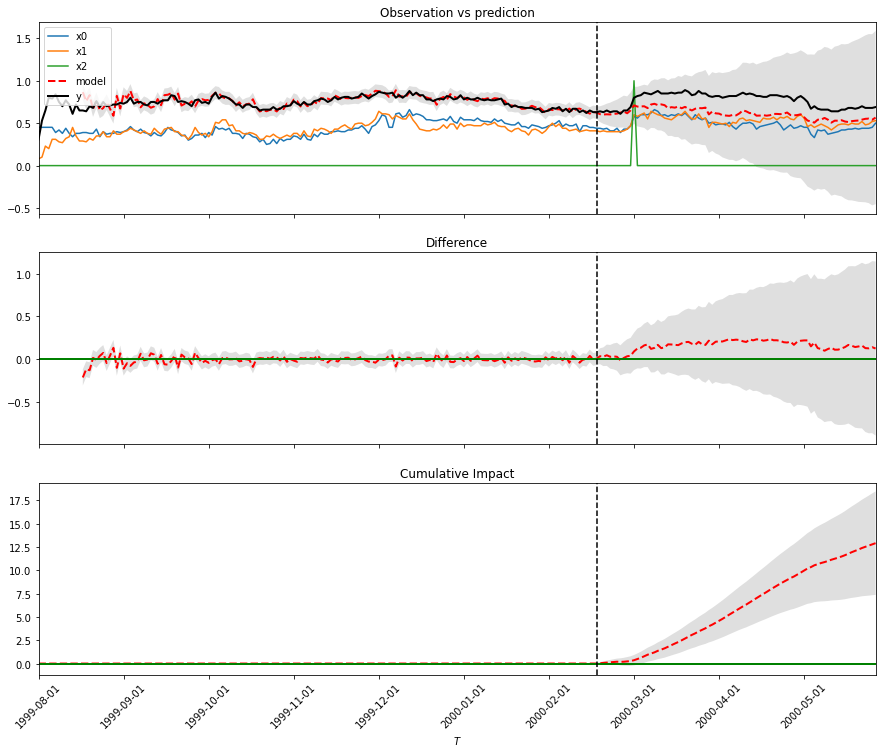

Тест Манна-Уитни для независимых величин
  Ho: Med(y) = Med(y_pred):      MannwhitneyuResult(statistic=9.0, pvalue=0.07652250047505922)
  Ho: Med(y) - Med(y_pred) < 0:  MannwhitneyuResult(statistic=9.0, pvalue=0.9865868904602293)
  Ho: Med(y) - Med(y_pred) > 0:  MannwhitneyuResult(statistic=9.0, pvalue=0.03826125023752961)

Тест Уилкоксона для зависимых величин
  Ho: Med(y) = Med(y_pred):      WilcoxonResult(statistic=0.0, pvalue=0.10880943004054568)
  Ho: Med(y) - Med(y_pred) < 0:  WilcoxonResult(statistic=6.0, pvalue=0.9455952849797271)
  Ho: Med(y) - Med(y_pred) > 0:  WilcoxonResult(statistic=6.0, pvalue=0.05440471502027284)

        y      pred
164  0.63  0.625378
165  0.64  0.606361
166  0.63  0.602568


In [11]:
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon

ci = CausalImpact(sample, '2013-04-01', n_seasons=12)
ci.run(max_iter=2000)
ci.plot()

df_out = pd.concat([data['Date'], ci.run(return_df=True)], axis=1)
df_out = df_out[df_out['Date'] >= '2013-04-01']
df_out.head()
to_test = df_out.iloc[:3,[1,5]]

print('Тест Манна-Уитни для независимых величин')
print('  Ho: Med(y) = Med(y_pred):     ', mannwhitneyu(to_test['y'], to_test['pred'], alternative='two-sided'))
print('  Ho: Med(y) - Med(y_pred) < 0: ', mannwhitneyu(to_test['y'], to_test['pred'], alternative='less'))
print('  Ho: Med(y) - Med(y_pred) > 0: ', mannwhitneyu(to_test['y'], to_test['pred'], alternative='greater'))
print('')
print('Тест Уилкоксона для зависимых величин')
print('  Ho: Med(y) = Med(y_pred):     ', wilcoxon(to_test['y'], to_test['pred'], alternative='two-sided'))
print('  Ho: Med(y) - Med(y_pred) < 0: ', wilcoxon(to_test['y'], to_test['pred'], alternative='less'))
print('  Ho: Med(y) - Med(y_pred) > 0: ', wilcoxon(to_test['y'], to_test['pred'], alternative='greater'))
print('')
print(to_test)

Например, здесь Y фактический после линии больше Y предсказанного, если бы не было линии. Положительный эффект линии на рейтинг президента.

### В нашем случае, эффект можно замерить двумя способами:
1. Разница между фактом после линии и предиктом после линии
2. Разница между фактом до и фактом после линии

### (1) Отчет для всех линий позднее 2012 года (это те, которые хорошо подогнаны)

График модели BSTS + Проверка результатов тестом Уилкокса: факты после vs. предикты после. Помним, что тест не всегда выдает адекватные результаты - могут приниматься 3 противоположные гипотезы. Такие моменты мы пропускаем.

C:\Users\nekit\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Результаты для линии 2001-12-01


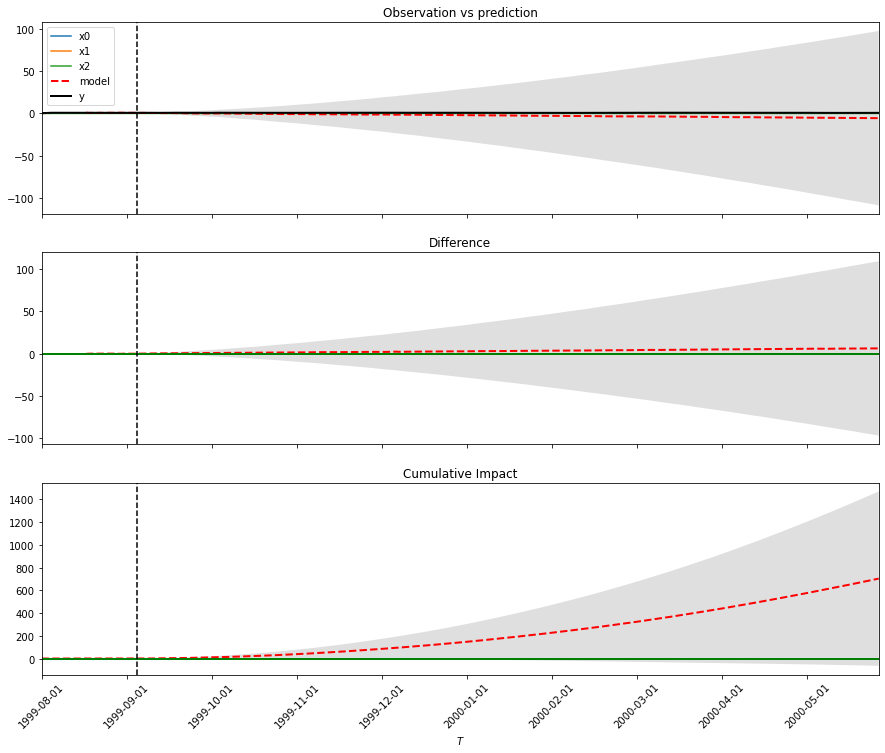

C:\Users\nekit\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Тест Манна-Уитни для независимых величин
  Ho: Med(y) = Med(y_pred):      MannwhitneyuResult(statistic=9.0, pvalue=0.07652250047505922)
  Ho: Med(y) - Med(y_pred) > 0:  MannwhitneyuResult(statistic=9.0, pvalue=0.9865868904602293)
  Ho: Med(y) - Med(y_pred) < 0:  MannwhitneyuResult(statistic=9.0, pvalue=0.03826125023752961)

Тест Уилкоксона для зависимых величин
  Ho: Med(y) = Med(y_pred):      WilcoxonResult(statistic=0.0, pvalue=0.10880943004054568)
  Ho: Med(y) - Med(y_pred) > 0:  WilcoxonResult(statistic=6.0, pvalue=0.9455952849797271)
  Ho: Med(y) - Med(y_pred) < 0:  WilcoxonResult(statistic=6.0, pvalue=0.05440471502027284)

       y      pred
28  0.73  0.712687
29  0.75  0.662351
30  0.75  0.606387


Результаты для линии 2002-12-01


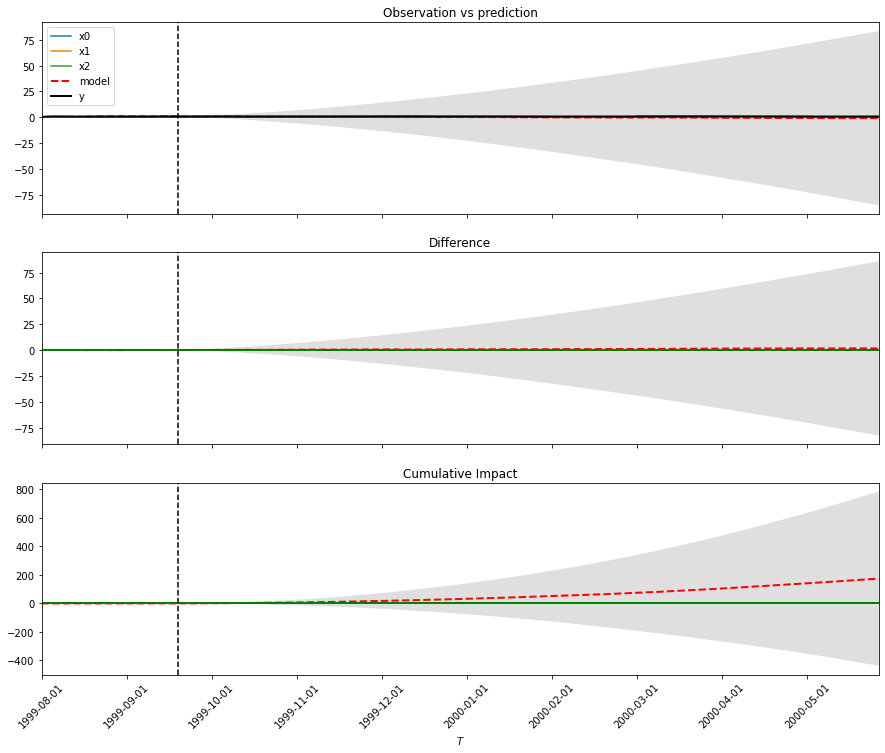

Тест Манна-Уитни для независимых величин
  Ho: Med(y) = Med(y_pred):      MannwhitneyuResult(statistic=8.0, pvalue=0.19043026382552397)
  Ho: Med(y) - Med(y_pred) > 0:  MannwhitneyuResult(statistic=8.0, pvalue=0.9595722008149739)
  Ho: Med(y) - Med(y_pred) < 0:  MannwhitneyuResult(statistic=8.0, pvalue=0.09521513191276199)

Тест Уилкоксона для зависимых величин
  Ho: Med(y) = Med(y_pred):      WilcoxonResult(statistic=1.0, pvalue=0.28504940740261275)
  Ho: Med(y) - Med(y_pred) > 0:  WilcoxonResult(statistic=5.0, pvalue=0.8574752962986936)
  Ho: Med(y) - Med(y_pred) < 0:  WilcoxonResult(statistic=5.0, pvalue=0.14252470370130638)

       y      pred
40  0.82  0.740981
41  0.75  0.750268
42  0.76  0.680609


Результаты для линии 2003-12-01


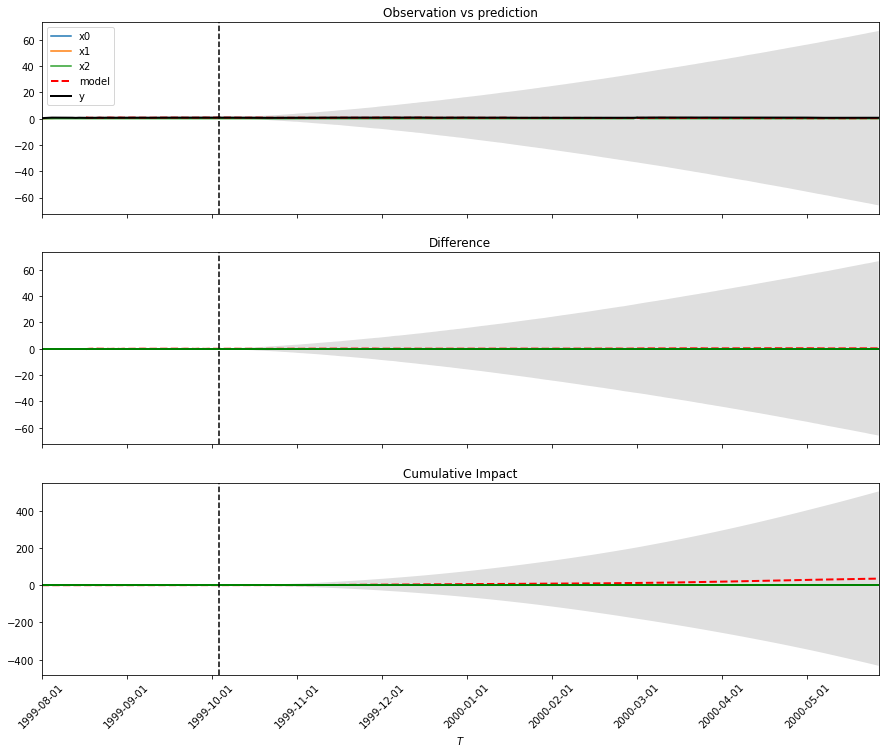

Тест Манна-Уитни для независимых величин
  Ho: Med(y) = Med(y_pred):      MannwhitneyuResult(statistic=6.0, pvalue=0.6625205835400574)
  Ho: Med(y) - Med(y_pred) > 0:  MannwhitneyuResult(statistic=6.0, pvalue=0.8086334555573871)
  Ho: Med(y) - Med(y_pred) < 0:  MannwhitneyuResult(statistic=6.0, pvalue=0.3312602917700287)

Тест Уилкоксона для зависимых величин
  Ho: Med(y) = Med(y_pred):      WilcoxonResult(statistic=0.0, pvalue=0.10880943004054568)
  Ho: Med(y) - Med(y_pred) > 0:  WilcoxonResult(statistic=6.0, pvalue=0.9455952849797271)
  Ho: Med(y) - Med(y_pred) < 0:  WilcoxonResult(statistic=6.0, pvalue=0.05440471502027284)

       y      pred
52  0.86  0.852813
53  0.79  0.787328
54  0.82  0.812378


Результаты для линии 2005-09-01


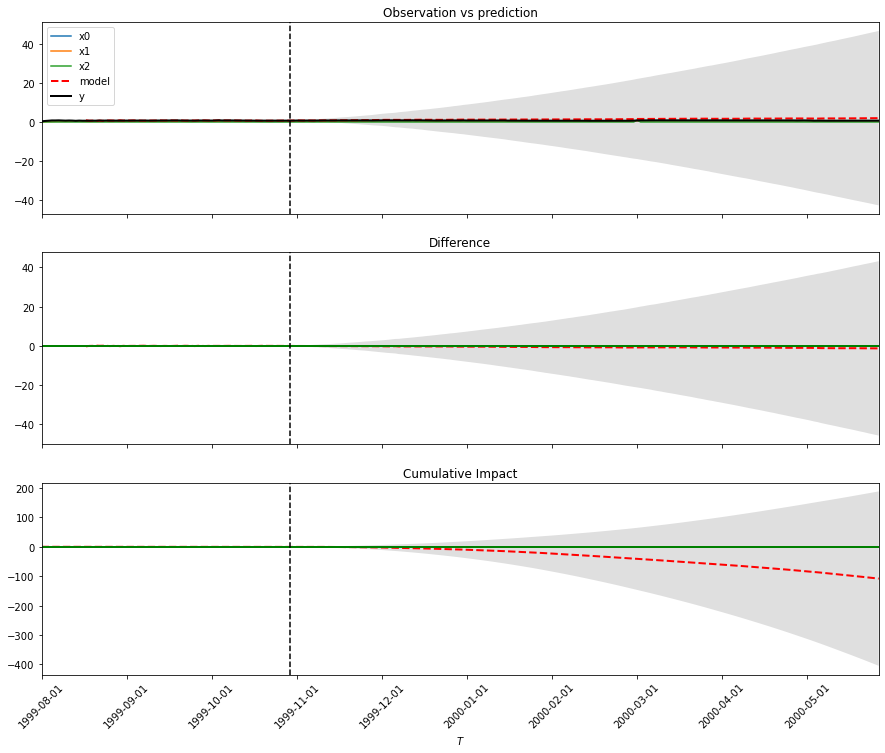

Тест Манна-Уитни для независимых величин
  Ho: Med(y) = Med(y_pred):      MannwhitneyuResult(statistic=2.0, pvalue=0.38273308888522595)
  Ho: Med(y) - Med(y_pred) > 0:  MannwhitneyuResult(statistic=2.0, pvalue=0.19136654444261297)
  Ho: Med(y) - Med(y_pred) < 0:  MannwhitneyuResult(statistic=2.0, pvalue=0.904784868087238)

Тест Уилкоксона для зависимых величин
  Ho: Med(y) = Med(y_pred):      WilcoxonResult(statistic=0.0, pvalue=0.10880943004054568)
  Ho: Med(y) - Med(y_pred) > 0:  WilcoxonResult(statistic=0.0, pvalue=0.05440471502027284)
  Ho: Med(y) - Med(y_pred) < 0:  WilcoxonResult(statistic=0.0, pvalue=0.9455952849797271)

       y      pred
73  0.70  0.727822
74  0.71  0.729887
75  0.76  0.789265


Результаты для линии 2006-10-01


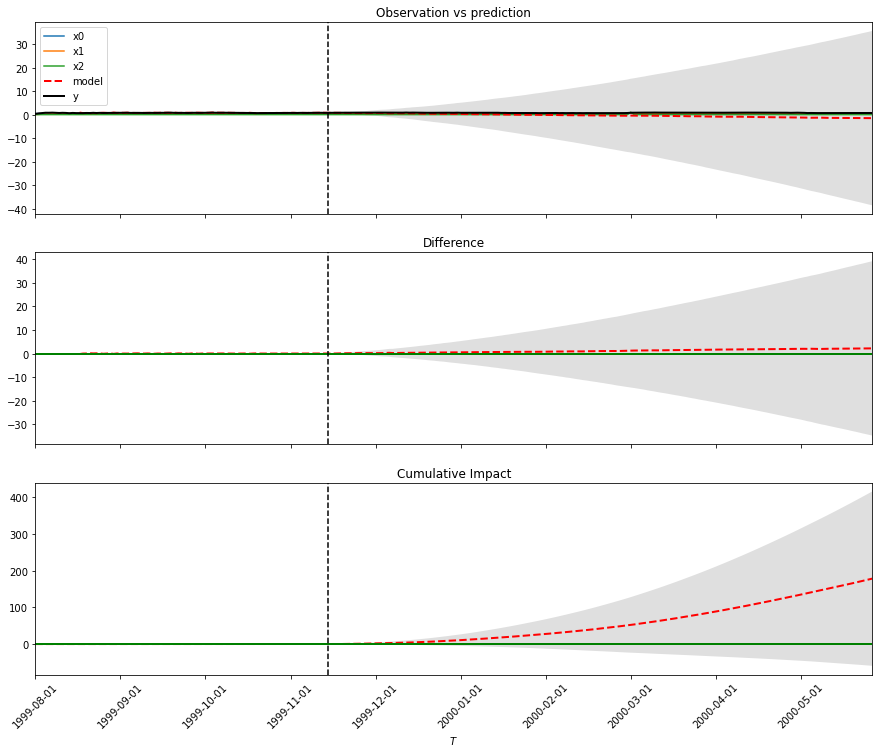

Тест Манна-Уитни для независимых величин
  Ho: Med(y) = Med(y_pred):      MannwhitneyuResult(statistic=7.0, pvalue=0.38273308888522595)
  Ho: Med(y) - Med(y_pred) > 0:  MannwhitneyuResult(statistic=7.0, pvalue=0.904784868087238)
  Ho: Med(y) - Med(y_pred) < 0:  MannwhitneyuResult(statistic=7.0, pvalue=0.19136654444261297)

Тест Уилкоксона для зависимых величин
  Ho: Med(y) = Med(y_pred):      WilcoxonResult(statistic=0.0, pvalue=0.10880943004054568)
  Ho: Med(y) - Med(y_pred) > 0:  WilcoxonResult(statistic=6.0, pvalue=0.9455952849797271)
  Ho: Med(y) - Med(y_pred) < 0:  WilcoxonResult(statistic=6.0, pvalue=0.05440471502027284)

       y      pred
86  0.77  0.760603
87  0.81  0.783624
88  0.78  0.758658




C:\Users\nekit\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Результаты для линии 2007-10-01


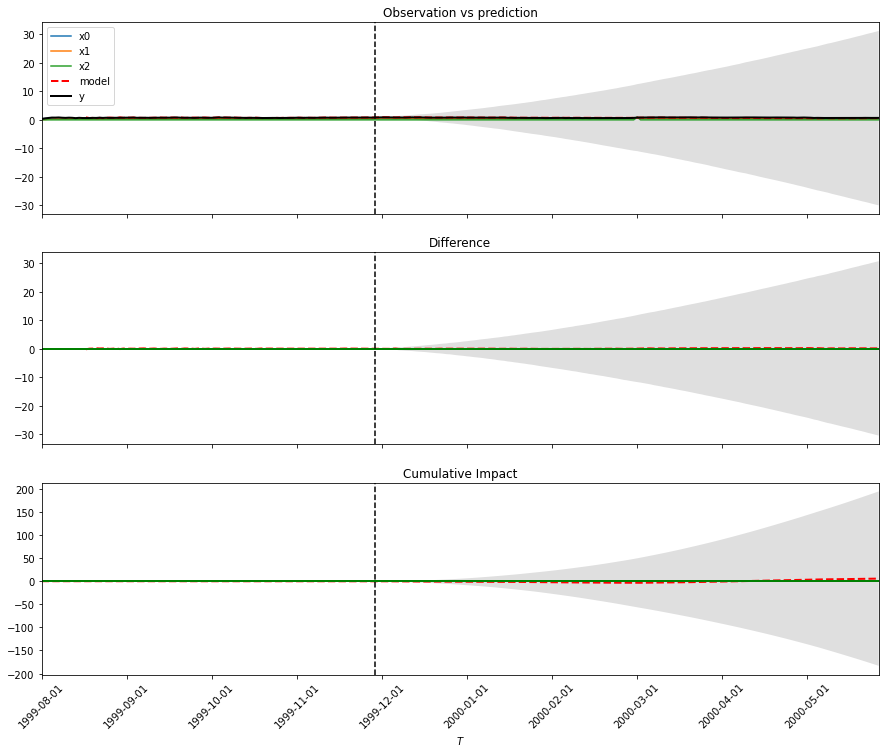

C:\Users\nekit\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Тест Манна-Уитни для независимых величин
  Ho: Med(y) = Med(y_pred):      MannwhitneyuResult(statistic=1.0, pvalue=0.19043026382552397)
  Ho: Med(y) - Med(y_pred) > 0:  MannwhitneyuResult(statistic=1.0, pvalue=0.09521513191276199)
  Ho: Med(y) - Med(y_pred) < 0:  MannwhitneyuResult(statistic=1.0, pvalue=0.9595722008149739)

Тест Уилкоксона для зависимых величин
  Ho: Med(y) = Med(y_pred):      WilcoxonResult(statistic=0.0, pvalue=0.10880943004054568)
  Ho: Med(y) - Med(y_pred) > 0:  WilcoxonResult(statistic=0.0, pvalue=0.05440471502027284)
  Ho: Med(y) - Med(y_pred) < 0:  WilcoxonResult(statistic=0.0, pvalue=0.9455952849797271)

        y      pred
98   0.82  0.851821
99   0.84  0.897048
100  0.87  0.914747


Результаты для линии 2008-11-01


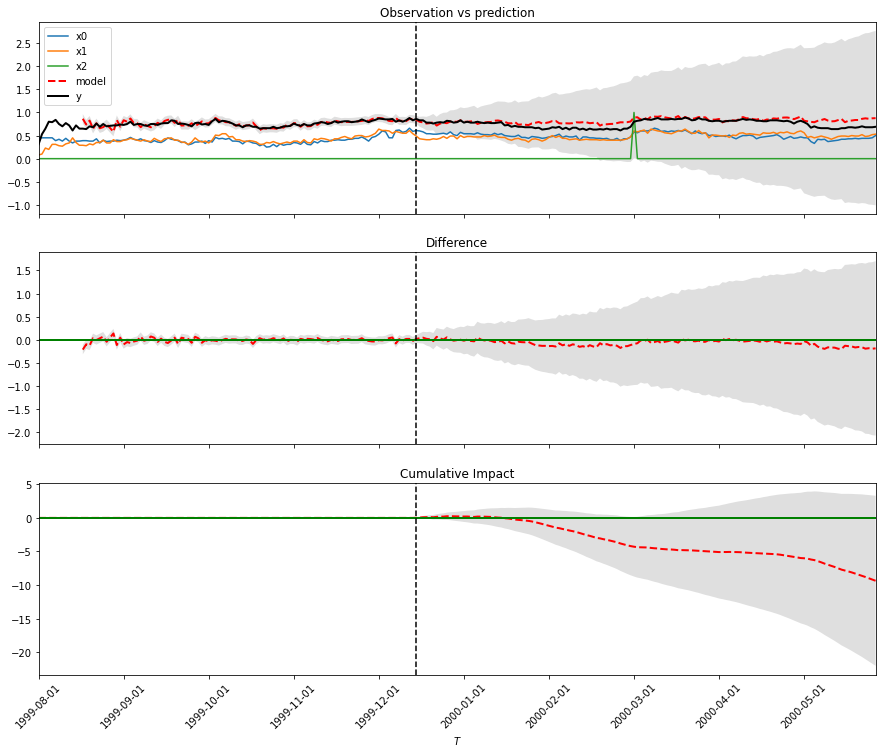

Тест Манна-Уитни для независимых величин
  Ho: Med(y) = Med(y_pred):      MannwhitneyuResult(statistic=7.0, pvalue=0.37582508748869836)
  Ho: Med(y) - Med(y_pred) > 0:  MannwhitneyuResult(statistic=7.0, pvalue=0.9079806864017873)
  Ho: Med(y) - Med(y_pred) < 0:  MannwhitneyuResult(statistic=7.0, pvalue=0.18791254374434918)

Тест Уилкоксона для зависимых величин
  Ho: Med(y) = Med(y_pred):      WilcoxonResult(statistic=0.0, pvalue=0.10880943004054568)
  Ho: Med(y) - Med(y_pred) > 0:  WilcoxonResult(statistic=6.0, pvalue=0.9455952849797271)
  Ho: Med(y) - Med(y_pred) < 0:  WilcoxonResult(statistic=6.0, pvalue=0.05440471502027284)

        y      pred
111  0.86  0.841545
112  0.83  0.799400
113  0.83  0.785175


Результаты для линии 2009-11-01


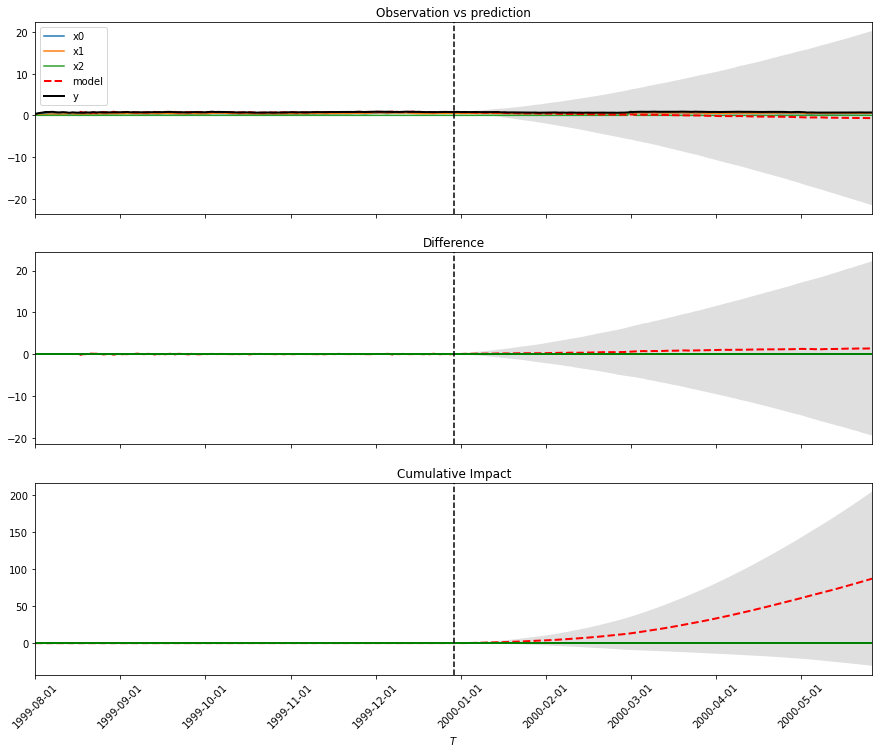

Тест Манна-Уитни для независимых величин
  Ho: Med(y) = Med(y_pred):      MannwhitneyuResult(statistic=6.0, pvalue=0.6625205835400574)
  Ho: Med(y) - Med(y_pred) > 0:  MannwhitneyuResult(statistic=6.0, pvalue=0.8086334555573871)
  Ho: Med(y) - Med(y_pred) < 0:  MannwhitneyuResult(statistic=6.0, pvalue=0.3312602917700287)

Тест Уилкоксона для зависимых величин
  Ho: Med(y) = Med(y_pred):      WilcoxonResult(statistic=0.0, pvalue=0.10880943004054568)
  Ho: Med(y) - Med(y_pred) > 0:  WilcoxonResult(statistic=6.0, pvalue=0.9455952849797271)
  Ho: Med(y) - Med(y_pred) < 0:  WilcoxonResult(statistic=6.0, pvalue=0.05440471502027284)

        y      pred
123  0.79  0.786555
124  0.83  0.795807
125  0.78  0.760533


Результаты для линии 2010-12-01


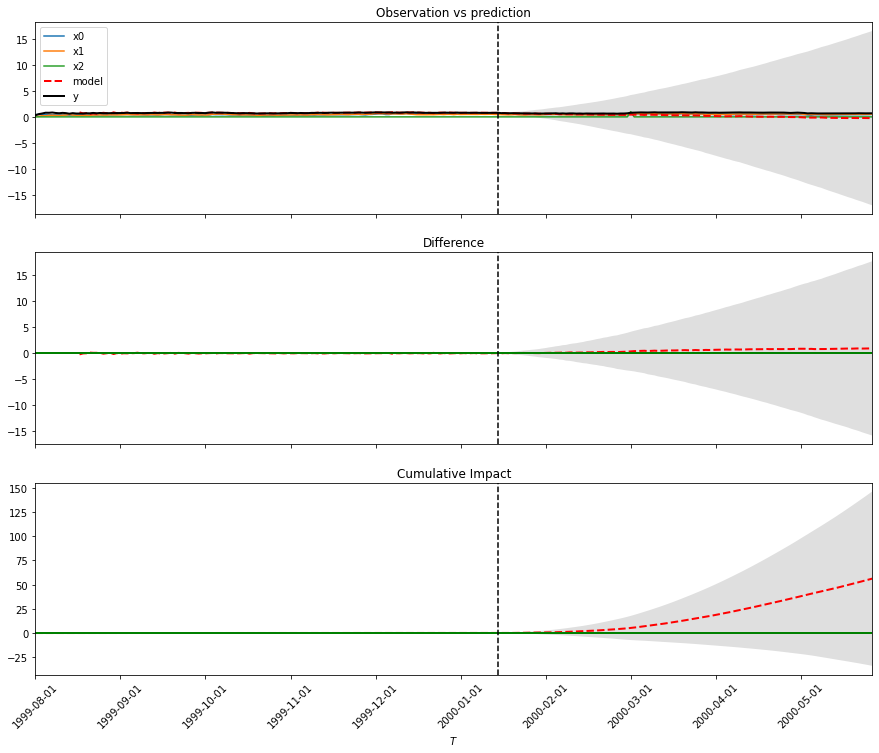

Тест Манна-Уитни для независимых величин
  Ho: Med(y) = Med(y_pred):      MannwhitneyuResult(statistic=6.0, pvalue=0.6625205835400574)
  Ho: Med(y) - Med(y_pred) > 0:  MannwhitneyuResult(statistic=6.0, pvalue=0.8086334555573871)
  Ho: Med(y) - Med(y_pred) < 0:  MannwhitneyuResult(statistic=6.0, pvalue=0.3312602917700287)

Тест Уилкоксона для зависимых величин
  Ho: Med(y) = Med(y_pred):      WilcoxonResult(statistic=1.0, pvalue=0.28504940740261275)
  Ho: Med(y) - Med(y_pred) > 0:  WilcoxonResult(statistic=5.0, pvalue=0.8574752962986936)
  Ho: Med(y) - Med(y_pred) < 0:  WilcoxonResult(statistic=5.0, pvalue=0.14252470370130638)

        y      pred
136  0.79  0.762591
137  0.72  0.728279
138  0.73  0.700169


Результаты для линии 2011-12-01


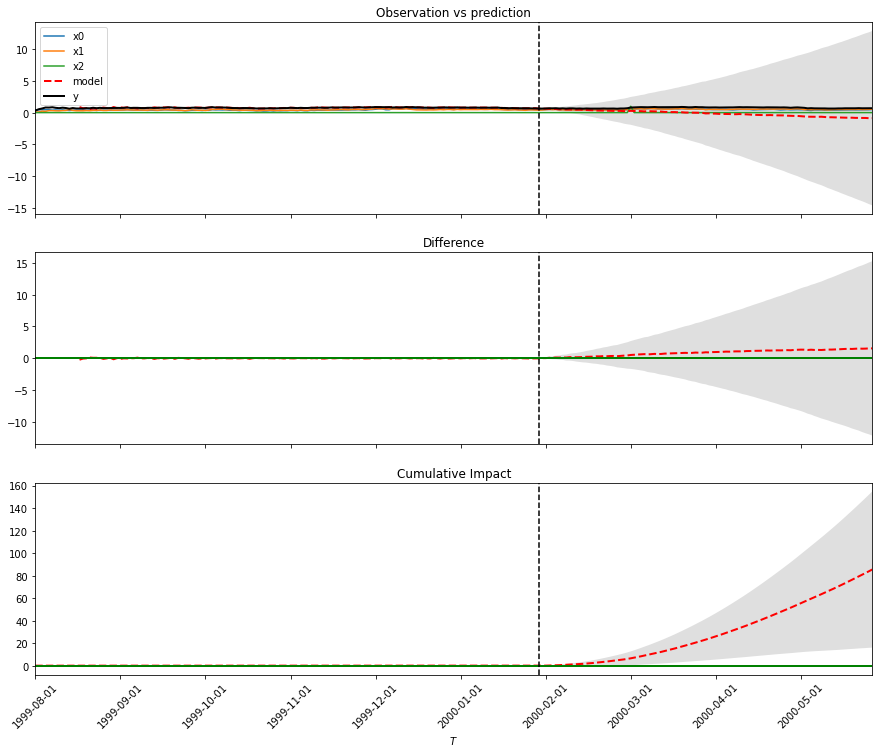

Тест Манна-Уитни для независимых величин
  Ho: Med(y) = Med(y_pred):      MannwhitneyuResult(statistic=7.0, pvalue=0.38273308888522595)
  Ho: Med(y) - Med(y_pred) > 0:  MannwhitneyuResult(statistic=7.0, pvalue=0.904784868087238)
  Ho: Med(y) - Med(y_pred) < 0:  MannwhitneyuResult(statistic=7.0, pvalue=0.19136654444261297)

Тест Уилкоксона для зависимых величин
  Ho: Med(y) = Med(y_pred):      WilcoxonResult(statistic=1.0, pvalue=0.28504940740261275)
  Ho: Med(y) - Med(y_pred) > 0:  WilcoxonResult(statistic=5.0, pvalue=0.8574752962986936)
  Ho: Med(y) - Med(y_pred) < 0:  WilcoxonResult(statistic=5.0, pvalue=0.14252470370130638)

        y      pred
148  0.63  0.642739
149  0.64  0.607622
150  0.65  0.617731


Результаты для линии 2013-04-01


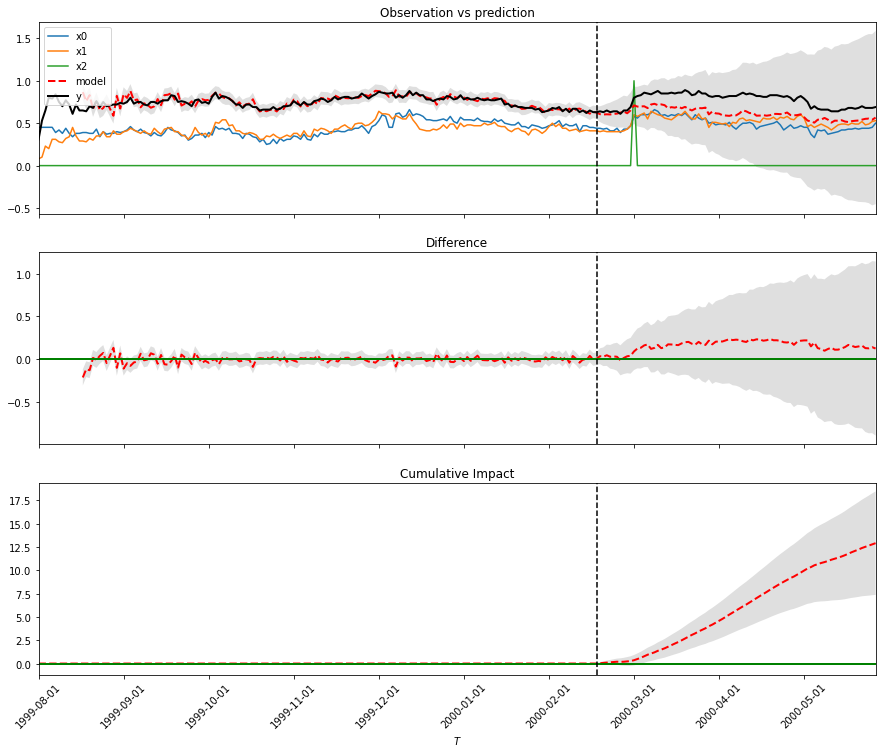

Тест Манна-Уитни для независимых величин
  Ho: Med(y) = Med(y_pred):      MannwhitneyuResult(statistic=9.0, pvalue=0.07652250047505922)
  Ho: Med(y) - Med(y_pred) > 0:  MannwhitneyuResult(statistic=9.0, pvalue=0.9865868904602293)
  Ho: Med(y) - Med(y_pred) < 0:  MannwhitneyuResult(statistic=9.0, pvalue=0.03826125023752961)

Тест Уилкоксона для зависимых величин
  Ho: Med(y) = Med(y_pred):      WilcoxonResult(statistic=0.0, pvalue=0.10880943004054568)
  Ho: Med(y) - Med(y_pred) > 0:  WilcoxonResult(statistic=6.0, pvalue=0.9455952849797271)
  Ho: Med(y) - Med(y_pred) < 0:  WilcoxonResult(statistic=6.0, pvalue=0.05440471502027284)

        y      pred
164  0.63  0.625378
165  0.64  0.606361
166  0.63  0.602568


Результаты для линии 2014-04-01


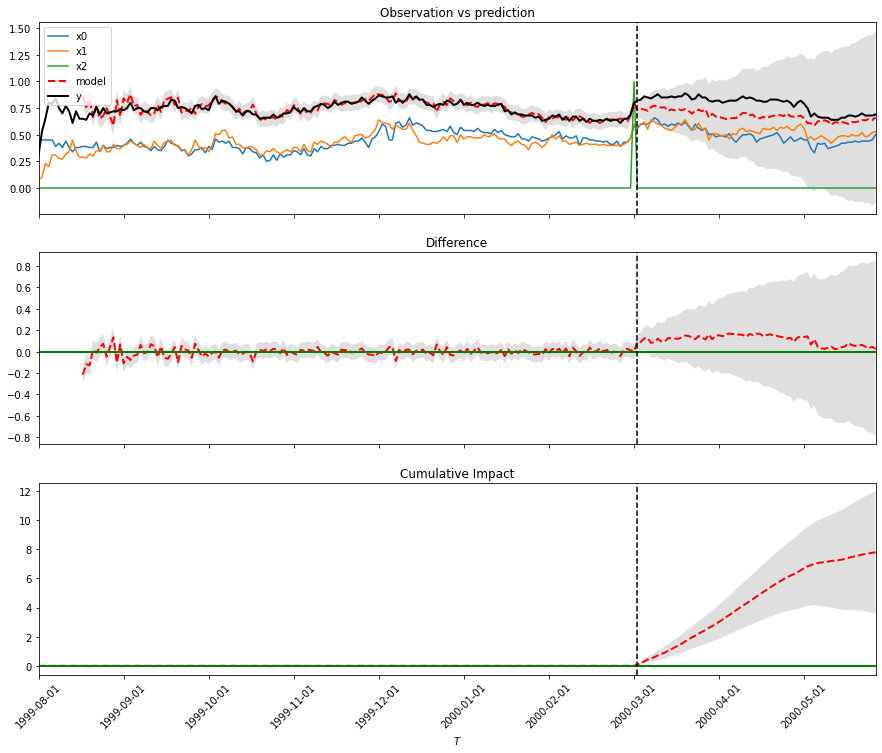

Тест Манна-Уитни для независимых величин
  Ho: Med(y) = Med(y_pred):      MannwhitneyuResult(statistic=9.0, pvalue=0.08085559837005224)
  Ho: Med(y) - Med(y_pred) > 0:  MannwhitneyuResult(statistic=9.0, pvalue=0.9854518341293739)
  Ho: Med(y) - Med(y_pred) < 0:  MannwhitneyuResult(statistic=9.0, pvalue=0.04042779918502612)

Тест Уилкоксона для зависимых величин
  Ho: Med(y) = Med(y_pred):      WilcoxonResult(statistic=0.0, pvalue=0.10880943004054568)
  Ho: Med(y) - Med(y_pred) > 0:  WilcoxonResult(statistic=6.0, pvalue=0.9455952849797271)
  Ho: Med(y) - Med(y_pred) < 0:  WilcoxonResult(statistic=6.0, pvalue=0.05440471502027284)

        y      pred
176  0.82  0.730825
177  0.83  0.741036
178  0.86  0.737315


Результаты для линии 2015-04-01


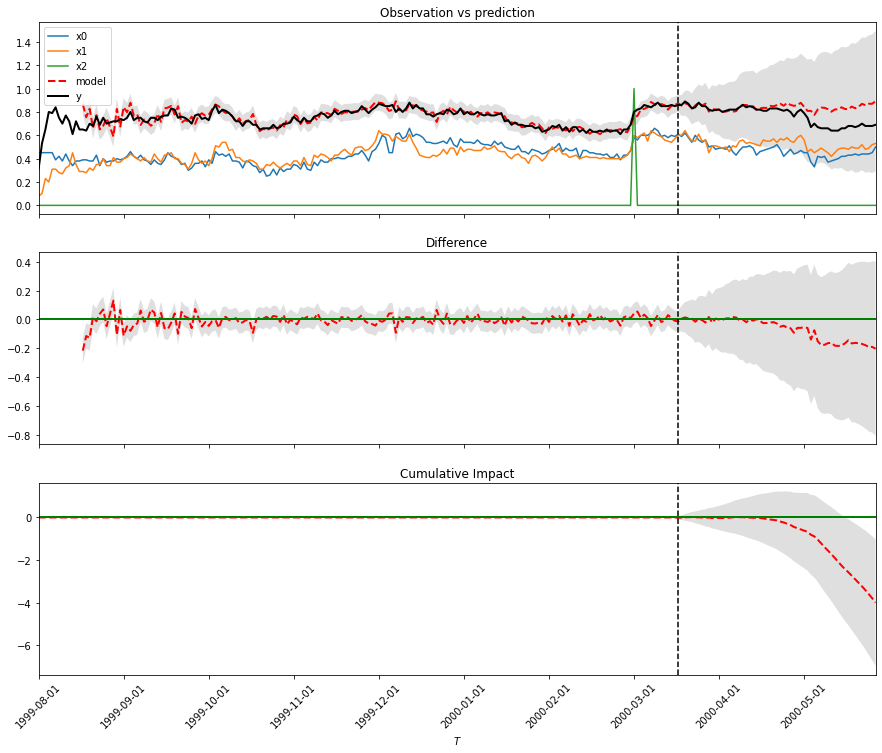

Тест Манна-Уитни для независимых величин
  Ho: Med(y) = Med(y_pred):      MannwhitneyuResult(statistic=5.0, pvalue=1.0)
  Ho: Med(y) - Med(y_pred) > 0:  MannwhitneyuResult(statistic=5.0, pvalue=0.6710474902857589)
  Ho: Med(y) - Med(y_pred) < 0:  MannwhitneyuResult(statistic=5.0, pvalue=0.5)

Тест Уилкоксона для зависимых величин
  Ho: Med(y) = Med(y_pred):      WilcoxonResult(statistic=2.0, pvalue=0.5929800980174267)
  Ho: Med(y) - Med(y_pred) > 0:  WilcoxonResult(statistic=4.0, pvalue=0.7035099509912867)
  Ho: Med(y) - Med(y_pred) < 0:  WilcoxonResult(statistic=4.0, pvalue=0.29649004900871334)

        y      pred
188  0.86  0.874051
189  0.86  0.854111
190  0.89  0.875862


Результаты для линии 2016-03-01


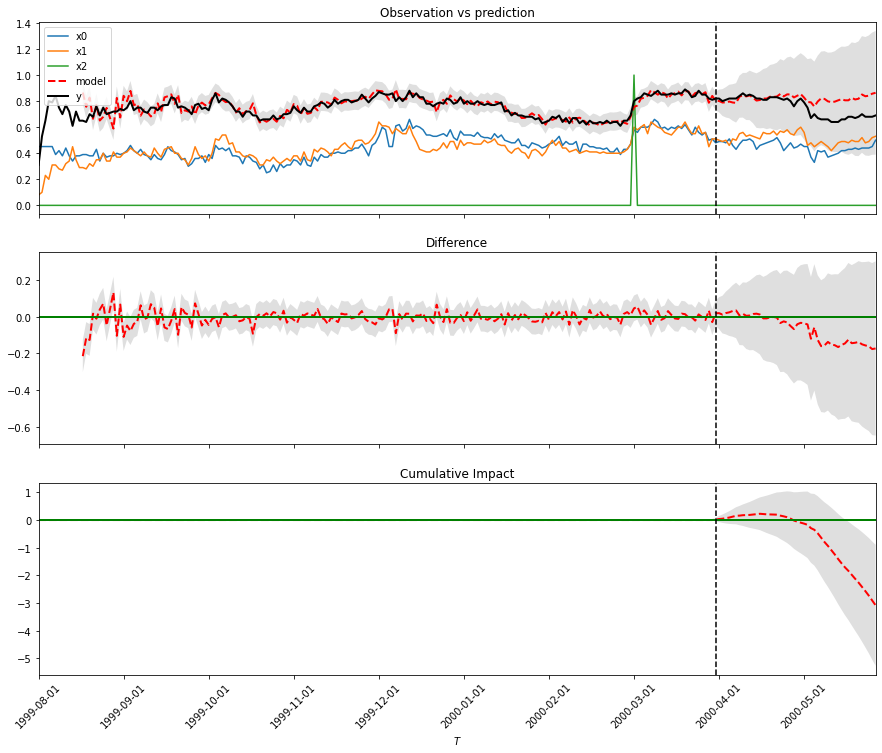

Тест Манна-Уитни для независимых величин
  Ho: Med(y) = Med(y_pred):      MannwhitneyuResult(statistic=7.0, pvalue=0.37582508748869836)
  Ho: Med(y) - Med(y_pred) > 0:  MannwhitneyuResult(statistic=7.0, pvalue=0.9079806864017873)
  Ho: Med(y) - Med(y_pred) < 0:  MannwhitneyuResult(statistic=7.0, pvalue=0.18791254374434918)

Тест Уилкоксона для зависимых величин
  Ho: Med(y) = Med(y_pred):      WilcoxonResult(statistic=0.0, pvalue=0.10880943004054568)
  Ho: Med(y) - Med(y_pred) > 0:  WilcoxonResult(statistic=6.0, pvalue=0.9455952849797271)
  Ho: Med(y) - Med(y_pred) < 0:  WilcoxonResult(statistic=6.0, pvalue=0.05440471502027284)

        y      pred
199  0.82  0.801943
200  0.82  0.801277
201  0.80  0.789179




C:\Users\nekit\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Результаты для линии 2017-06-01


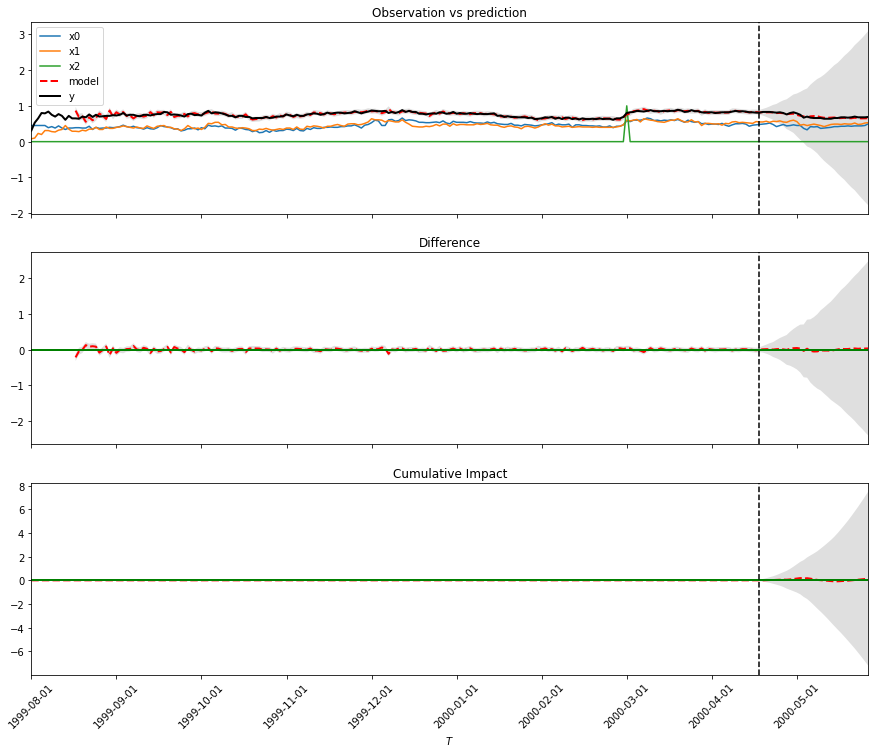

C:\Users\nekit\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Тест Манна-Уитни для независимых величин
  Ho: Med(y) = Med(y_pred):      MannwhitneyuResult(statistic=6.0, pvalue=0.6579050194284821)
  Ho: Med(y) - Med(y_pred) > 0:  MannwhitneyuResult(statistic=6.0, pvalue=0.8120874562556508)
  Ho: Med(y) - Med(y_pred) < 0:  MannwhitneyuResult(statistic=6.0, pvalue=0.32895250971424106)

Тест Уилкоксона для зависимых величин
  Ho: Med(y) = Med(y_pred):      WilcoxonResult(statistic=1.0, pvalue=0.28504940740261275)
  Ho: Med(y) - Med(y_pred) > 0:  WilcoxonResult(statistic=5.0, pvalue=0.8574752962986936)
  Ho: Med(y) - Med(y_pred) < 0:  WilcoxonResult(statistic=5.0, pvalue=0.14252470370130638)

        y      pred
214  0.81  0.816320
215  0.83  0.821986
216  0.83  0.818275


Результаты для линии 2018-05-01


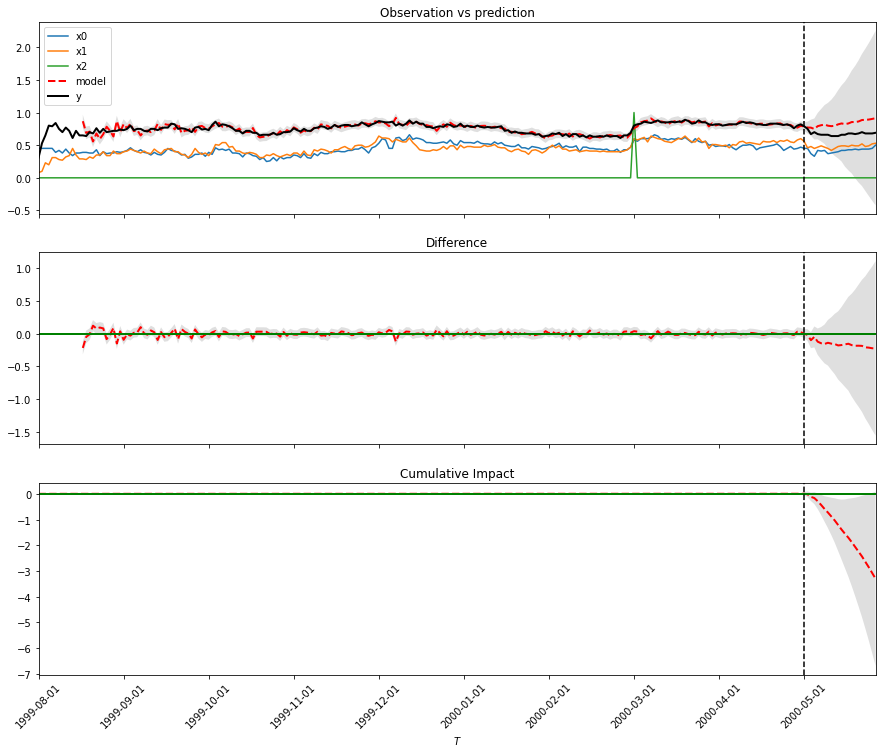

Тест Манна-Уитни для независимых величин
  Ho: Med(y) = Med(y_pred):      MannwhitneyuResult(statistic=3.0, pvalue=0.6625205835400574)
  Ho: Med(y) - Med(y_pred) > 0:  MannwhitneyuResult(statistic=3.0, pvalue=0.3312602917700287)
  Ho: Med(y) - Med(y_pred) < 0:  MannwhitneyuResult(statistic=3.0, pvalue=0.8086334555573871)

Тест Уилкоксона для зависимых величин
  Ho: Med(y) = Med(y_pred):      WilcoxonResult(statistic=1.0, pvalue=0.28504940740261275)
  Ho: Med(y) - Med(y_pred) > 0:  WilcoxonResult(statistic=1.0, pvalue=0.14252470370130638)
  Ho: Med(y) - Med(y_pred) < 0:  WilcoxonResult(statistic=1.0, pvalue=0.8574752962986936)

            y      pred
225  0.790000  0.787609
226  0.750285  0.770736
227  0.670000  0.768806


Результаты для линии 2019-06-01


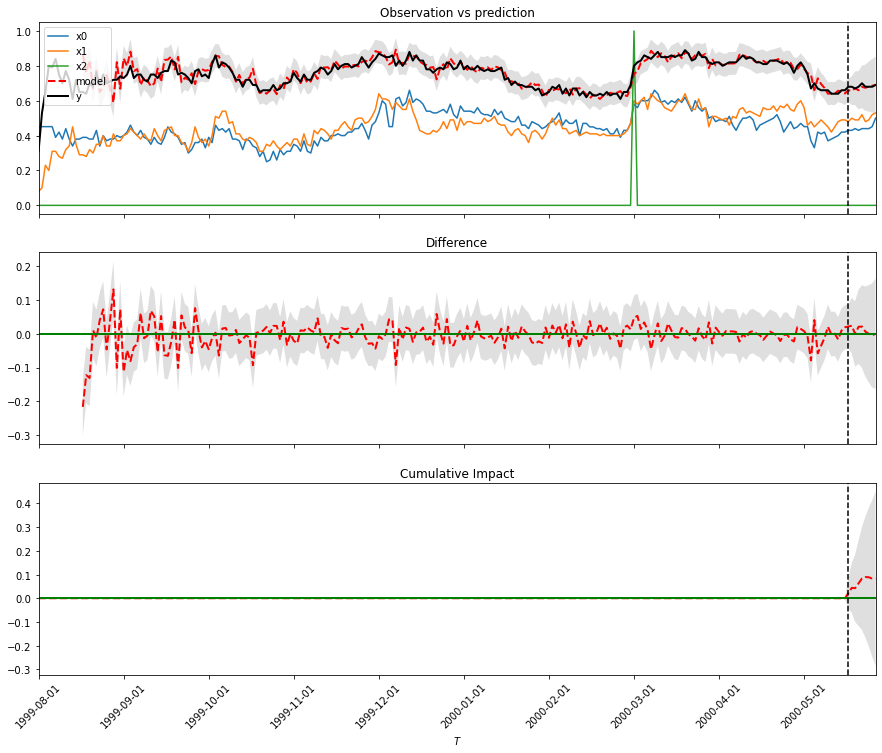

Тест Манна-Уитни для независимых величин
  Ho: Med(y) = Med(y_pred):      MannwhitneyuResult(statistic=8.0, pvalue=0.1840386271964254)
  Ho: Med(y) - Med(y_pred) > 0:  MannwhitneyuResult(statistic=8.0, pvalue=0.9617387497624704)
  Ho: Med(y) - Med(y_pred) < 0:  MannwhitneyuResult(statistic=8.0, pvalue=0.0920193135982127)

Тест Уилкоксона для зависимых величин
  Ho: Med(y) = Med(y_pred):      WilcoxonResult(statistic=1.0, pvalue=0.28504940740261275)
  Ho: Med(y) - Med(y_pred) > 0:  WilcoxonResult(statistic=5.0, pvalue=0.8574752962986936)
  Ho: Med(y) - Med(y_pred) < 0:  WilcoxonResult(statistic=5.0, pvalue=0.14252470370130638)

        y      pred
238  0.68  0.659304
239  0.68  0.656920
240  0.67  0.671180




In [14]:
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt

for i in date_interv:
    #if i >= '2013-04-01':
        ci = CausalImpact(sample, i, n_seasons=12)
        ci.run(max_iter=2000)
        print('Результаты для линии', i)
        ci.plot()

        df_out = pd.concat([data['Date'], ci.run(return_df=True)], axis=1)
        df_out = df_out[df_out['Date'] >= i]
        df_out.head()
        to_test = df_out.iloc[:3,[1,5]]

        print('Тест Манна-Уитни для независимых величин')
        print('  Ho: Med(y) = Med(y_pred):     ', mannwhitneyu(to_test['y'], to_test['pred'], alternative='two-sided'))
        print('  Ho: Med(y) - Med(y_pred) > 0: ', mannwhitneyu(to_test['y'], to_test['pred'], alternative='less'))
        print('  Ho: Med(y) - Med(y_pred) < 0: ', mannwhitneyu(to_test['y'], to_test['pred'], alternative='greater'))
        print('')
        print('Тест Уилкоксона для зависимых величин')
        print('  Ho: Med(y) = Med(y_pred):     ', wilcoxon(to_test['y'], to_test['pred'], alternative='two-sided'))
        print('  Ho: Med(y) - Med(y_pred) > 0: ', wilcoxon(to_test['y'], to_test['pred'], alternative='less'))
        print('  Ho: Med(y) - Med(y_pred) < 0: ', wilcoxon(to_test['y'], to_test['pred'], alternative='greater'))
        print('')
        print(to_test)
        print('')
        print('')

### (2) Только Wilcoxon test. Сравниваем рейтинг 'до' и 'после' прямой линии (3 мес. для каждого случая)

In [42]:
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon

for i in date_interv:
    # Готовим датафрейм с рейтингами до и после (3 мес.)
    before = data[data['Date'] < i].iloc[[-3,-2,-1],:]
    before = before[['Pres_Approve']].reset_index(drop=True)
    
    after = data[data['Date'] > i].iloc[:3,:]
    after = after[['Pres_Approve']].reset_index(drop=True)
    
    to_test = pd.concat([before, after], ignore_index=True, axis=1)
    to_test = to_test.rename(columns={0: 'y_before', 1: 'y_after'})

    print('Результаты для линии', i)
    print('')
    print('Тест Манна-Уитни для независимых величин')
    print('  Ho: Med(y_before) = Med(y_after):     ', mannwhitneyu(to_test['y_before'], to_test['y_after'], alternative='two-sided'))
    print('  Ho: Med(y_before) - Med(y_after) > 0: ', mannwhitneyu(to_test['y_before'], to_test['y_after'], alternative='less'))
    print('  Ho: Med(y_before) - Med(y_after) < 0: ', mannwhitneyu(to_test['y_before'], to_test['y_after'], alternative='greater'))
    print('')
    print('Тест Уилкоксона для зависимых величин')
    print('  Ho: Med(y_before) = Med(y_after):     ', wilcoxon(to_test['y_before'], to_test['y_after'], alternative='two-sided'))
    print('  Ho: Med(y_before) - Med(y_after) > 0: ', wilcoxon(to_test['y_before'], to_test['y_after'], alternative='less'))
    print('  Ho: Med(y_before) - Med(y_after) < 0: ', wilcoxon(to_test['y_before'], to_test['y_after'], alternative='greater'))
    print('')
    print(to_test)
    print('')
    print('')

Результаты для линии 2001-12-01

Тест Манна-Уитни для независимых величин
  Ho: Med(y_before) = Med(y_after):      MannwhitneyuResult(statistic=6.0, pvalue=0.6428348264908041)
  Ho: Med(y_before) - Med(y_after) > 0:  MannwhitneyuResult(statistic=6.0, pvalue=0.8231607413407676)
  Ho: Med(y_before) - Med(y_after) < 0:  MannwhitneyuResult(statistic=6.0, pvalue=0.3214174132454021)

Тест Уилкоксона для зависимых величин
  Ho: Med(y_before) = Med(y_after):      WilcoxonResult(statistic=1.0, pvalue=0.6547208460185769)
  Ho: Med(y_before) - Med(y_after) > 0:  WilcoxonResult(statistic=2.0, pvalue=0.6726395769907115)
  Ho: Med(y_before) - Med(y_after) < 0:  WilcoxonResult(statistic=2.0, pvalue=0.32736042300928847)

   y_before  y_after
0      73.0     75.0
1      75.0     75.0
2      80.0     72.0


Результаты для линии 2002-12-01

Тест Манна-Уитни для независимых величин
  Ho: Med(y_before) = Med(y_after):      MannwhitneyuResult(statistic=9.0, pvalue=0.07219819770165753)
  Ho: Med(y_before) - 

In [43]:
df_out

,Date,y,x0,x1,x2,pred,pred_conf_int_lower,pred_conf_int_upper,pred_diff,pred_diff_conf_int_lower,pred_diff_conf_int_upper,cum_impact,cum_impact_conf_int_lower,cum_impact_conf_int_upper
238,2019-06-01,68.0,43.000000,48.0,0,66.238325,59.656754,72.819896,1.761675,-4.819896,8.343246,1.761675,-4.819896,8.343246
239,2019-07-01,68.0,43.000000,50.0,0,66.935953,57.964610,75.907296,1.064047,-7.907296,10.035390,2.825722,-8.300916,13.952360
240,2019-08-01,67.0,44.000000,49.0,0,68.549793,56.396200,80.703387,-1.549793,-13.703387,10.603800,1.275929,-15.201690,17.753547
241,2019-09-01,68.0,43.000000,49.0,0,68.082863,52.216017,83.949710,-0.082863,-15.949710,15.783983,1.193065,-21.682003,24.068133
242,2019-10-01,70.0,44.000000,52.0,0,70.222110,50.214102,90.230118,-0.222110,-20.230118,19.785898,0.970955,-29.419654,31.361565
243,2019-11-01,68.0,44.000000,48.0,0,70.421037,45.903550,94.938524,-2.421037,-26.938524,22.096450,-1.450082,-40.497441,37.597278
244,2019-12-01,68.0,44.000000,49.0,0,71.234563,41.877974,100.591152,-3.234563,-32.591152,26.122026,-4.684645,-53.536519,44.167229
245,2020-01-01,68.0,45.135021,52.0,0,71.718429,37.220601,106.216257,-3.718429,-38.216257,30.779399,-8.403074,-68.207804,51.401656
246,2020-02-01,69.0,50.000000,53.0,0,72.977161,33.058253,112.896068,-3.977161,-43.896068,35.941747,-12.380234,-84.283815,59.523346


### Итак, что мы получили. Выносим в столбец все результаты тестов и BSTS+тестов (где нормально построилось)

In [166]:
results = pd.DataFrame(
            {"Line_Date": ['2001-12-01', '2002-12-01', '2003-12-01', '2005-09-01',
                           '2006-10-01', '2007-10-01', '2008-11-01', '2009-11-01',
                           '2010-12-01', '2011-12-01', '2013-04-01', '2014-04-01',
                           '2015-04-01', '2016-03-01', '2017-06-01', '2018-05-01', 
                           '2019-06-01'],
                        
            "Гипотезы противоречат (тест)": ['да', 'нет', 'нет', 'нет',
                                             'нет', 'да', 'нет', 'да',
                                             'нет', 'да', 'да', 'нет',
                                             'нет', 'нет', 'нет', 'да', 'нет'],
                        
            "Тест, Результат (до и после)": ['', 'y_before ≥ y_after (*)', 'y_before ≤ y_after (*)', 'y_before ≤ y_after (*)',
                                             'y_before ≤ y_after (*)', '', 'y_before ≥ y_after (*)', '',
                                             'y_before ≥ y_after (*)', '', '', 'y_before ≤ y_after (*)', 
                                             'y_before ≤ y_after (*)', 'y_before ≥ y_after (*)', 'y_before ≤ y_after (*)', '', 
                                             'y_before ≤ y_after (*)'],
             
             "Гипотезы противоречат (BSTS+тест)": ['нет', 'да', 'нет', 'нет',
                                                   'нет', 'нет', 'нет', 'нет',
                                                   'да', 'да', 'нет', 'нет',
                                                   'да', 'нет', 'да', 'да', 'да'],
                        
            "BSTS+Тест, Результат (факт и прогноз)": ['y_fact ≥ y_pred (*)', '', 'y_fact ≥ y_pred (*)', 'y_fact ≤ y_pred (*)',
                                                      'y_fact ≥ y_pred (*)', 'y_fact ≤ y_pred (*)', 'y_fact ≥ y_pred (*)', 'y_fact ≥ y_pred (*)',
                                                      '', '', 'y_fact ≥ y_pred (*)', 'y_fact ≥ y_pred (*)', 
                                                      '', 'y_fact ≥ y_pred (*)', '', '', '']})
results

,Line_Date,Гипотезы противоречат (тест),"Тест, Результат (до и после)",Гипотезы противоречат (BSTS+тест),"BSTS+Тест, Результат (факт и прогноз)"
0,2001-12-01,да,,нет,y_fact ≥ y_pred (*)
1,2002-12-01,нет,y_before ≥ y_after (*),да,
2,2003-12-01,нет,y_before ≤ y_after (*),нет,y_fact ≥ y_pred (*)
3,2005-09-01,нет,y_before ≤ y_after (*),нет,y_fact ≤ y_pred (*)
4,2006-10-01,нет,y_before ≤ y_after (*),нет,y_fact ≥ y_pred (*)
5,2007-10-01,да,,нет,y_fact ≤ y_pred (*)
6,2008-11-01,нет,y_before ≥ y_after (*),нет,y_fact ≥ y_pred (*)
7,2009-11-01,да,,нет,y_fact ≥ y_pred (*)
8,2010-12-01,нет,y_before ≥ y_after (*),да,
9,2011-12-01,да,,да,


По ожидаемым результатам. Рейтинг после должен быть больше рейтинга до, а фактический рейтинг после должен быть больше предсказанного BSTS (т.к. это если бы линиии не было). Все-таки, мы доверяем больше простому тесту Уилкокса, т.к. он основан на фактах. Будем заполнять пропуски у результатов теста результатами BSTS.

# -----------------------------------------------------------------------------------------------------------------

## Новая попытка посчитать эффект

### 1. Рейтинг президента

In [49]:
# Индексы линий
indexes = data[data['Was_Line'] == 1].index.tolist()

one_m_before_rank = []
one_m_after_rank = []

two_m_before_rank = []
two_m_after_rank = []

three_m_before_rank = []
three_m_after_rank = []

for i in indexes:
    one_m_before_rank.append(data.iloc[i-1,:]['Pres_Approve'])
    one_m_after_rank.append(data.iloc[i+1,:]['Pres_Approve'])
    
    two_m_before_rank.append(data.iloc[[i-1, i-2],:]['Pres_Approve'].tolist())
    two_m_after_rank.append(data.iloc[[i+1, i+2],:]['Pres_Approve'].tolist())
    
    three_m_before_rank.append(data.iloc[[i-1, i-2, i-3],:]['Pres_Approve'].tolist())
    three_m_after_rank.append(data.iloc[[i+1, i+2, i+3],:]['Pres_Approve'].tolist())

two_m_before_rank = [item for sublist in two_m_before_rank for item in sublist]
two_m_after_rank = [item for sublist in  two_m_after_rank for item in sublist]

three_m_before_rank = [item for sublist in three_m_before_rank for item in sublist]
three_m_after_rank = [item for sublist in  three_m_after_rank for item in sublist]

print(three_m_before_rank)

[80.0, 75.0, 73.0, 83.0, 77.0, 77.0, 81.0, 73.0, 75.0, 70.0, 67.0, 66.0, 75.0, 78.0, 79.0, 79.0, 82.0, 85.0, 83.0, 88.0, 83.0, 78.0, 81.0, 82.0, 78.0, 77.0, 77.0, 67.0, 66.0, 68.0, 63.0, 65.0, 62.0, 80.0, 69.0, 65.0, 85.0, 86.0, 85.0, 81.0, 82.0, 85.0, 81.0, 82.0, 82.0, 82.0, 80.0, 76.0, 66.0, 66.0, 64.0]


In [66]:
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon

for pair in [[one_m_before_rank, one_m_after_rank], 
             [two_m_before_rank, two_m_after_rank], 
             [three_m_before_rank, three_m_after_rank]]:
    print('Пара:')
    print(*pair, sep='\n')
    print('')
    print('Тест Манна-Уитни для независимых величин')
    print('  Ho: Med(y_before) = Med(y_after):     ', 'p-val =', round(mannwhitneyu(pair[0], pair[1], alternative='two-sided')[1], 3))
    print('  Ho: Med(y_before) - Med(y_after) > 0: ', 'p-val =', round(mannwhitneyu(pair[0], pair[1], alternative='less')[1], 3))
    print('  Ho: Med(y_before) - Med(y_after) < 0: ', 'p-val =', round(mannwhitneyu(pair[0], pair[1], alternative='greater')[1], 3))
    print('')
    print('Тест Уилкоксона для зависимых величин')
    print('  Ho: Med(y_before) = Med(y_after):     ', 'p-val =', round(wilcoxon(pair[0], pair[1], alternative='two-sided')[1], 3))
    print('  Ho: Med(y_before) - Med(y_after) > 0: ', 'p-val =', round(wilcoxon(pair[0], pair[1], alternative='less')[1], 3))
    print('  Ho: Med(y_before) - Med(y_after) < 0: ', 'p-val =', round(wilcoxon(pair[0], pair[1], alternative='greater')[1], 3))
    print('')

Пара:
[80.0, 83.0, 81.0, 70.0, 75.0, 79.0, 83.0, 78.0, 78.0, 67.0, 63.0, 80.0, 85.0, 81.0, 81.0, 82.0, 66.0]
[75.0, 75.0, 79.0, 71.0, 81.0, 84.0, 83.0, 83.0, 72.0, 64.0, 64.0, 83.0, 86.0, 82.0, 83.0, nan, 68.0]

Тест Манна-Уитни для независимых величин
  Ho: Med(y_before) = Med(y_after):      p-val = 0.5
  Ho: Med(y_before) - Med(y_after) > 0:  p-val = 0.25
  Ho: Med(y_before) - Med(y_after) < 0:  p-val = 0.761

Тест Уилкоксона для зависимых величин
  Ho: Med(y_before) = Med(y_after):      p-val = 0.468
  Ho: Med(y_before) - Med(y_after) > 0:  p-val = 0.234
  Ho: Med(y_before) - Med(y_after) < 0:  p-val = 0.766

Пара:
[80.0, 75.0, 83.0, 77.0, 81.0, 73.0, 70.0, 67.0, 75.0, 78.0, 79.0, 82.0, 83.0, 88.0, 78.0, 81.0, 78.0, 77.0, 67.0, 66.0, 63.0, 65.0, 80.0, 69.0, 85.0, 86.0, 81.0, 82.0, 81.0, 82.0, 82.0, 80.0, 66.0, 66.0]
[75.0, 75.0, 75.0, 76.0, 79.0, 82.0, 71.0, 76.0, 81.0, 78.0, 84.0, 87.0, 83.0, 83.0, 83.0, 78.0, 72.0, 73.0, 64.0, 65.0, 64.0, 63.0, 83.0, 86.0, 86.0, 89.0, 82.0, 80.0, 

### 2. Рейтинг правительства

In [52]:
# Индексы линий
indexes = data[data['Was_Line'] == 1].index.tolist()

one_m_before_gov = []
one_m_after_gov = []

two_m_before_gov = []
two_m_after_gov = []

three_m_before_gov = []
three_m_after_gov = []

for i in indexes:
    one_m_before_gov.append(data.iloc[i-1,:]['Gov_Approve'])
    one_m_after_gov.append(data.iloc[i+1,:]['Gov_Approve'])
    
    two_m_before_gov.append(data.iloc[[i-1, i-2],:]['Gov_Approve'].tolist())
    two_m_after_gov.append(data.iloc[[i+1, i+2],:]['Gov_Approve'].tolist())
    
    three_m_before_gov.append(data.iloc[[i-1, i-2, i-3],:]['Gov_Approve'].tolist())
    three_m_after_gov.append(data.iloc[[i+1, i+2, i+3],:]['Gov_Approve'].tolist())

two_m_before_gov = [item for sublist in two_m_before_gov for item in sublist]
two_m_after_gov = [item for sublist in  two_m_after_gov for item in sublist]

three_m_before_gov = [item for sublist in three_m_before_gov for item in sublist]
three_m_after_gov = [item for sublist in  three_m_after_gov for item in sublist]

print(three_m_before_gov)

[46.0, 42.0, 40.0, 42.0, 45.0, 39.0, 36.0, 39.0, 33.0, 29.0, 32.0, 26.0, 37.0, 37.0, 39.0, 38.0, 43.0, 47.0, 59.0, 66.0, 59.0, 52.0, 58.0, 53.0, 52.0, 55.0, 51.0, 46.0, 47.0, 48.0, 45.0, 45.0, 47.0, 58.0, 47.0, 43.0, 59.0, 60.0, 58.0, 51.0, 50.0, 56.0, 47.0, 46.0, 43.0, 47.0, 45.0, 44.0, 42.0, 42.0, 40.0]


In [67]:
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon

for pair in [[one_m_before_gov, one_m_after_gov], 
             [two_m_before_gov, two_m_after_gov], 
             [three_m_before_gov, three_m_after_gov]]:
    print('Пара:')
    print(*pair, sep='\n')
    print('')
    print('Тест Манна-Уитни для независимых величин')
    print('  Ho: Med(y_before) = Med(y_after):     ', 'p-val =', round(mannwhitneyu(pair[0], pair[1], alternative='two-sided')[1], 3))
    print('  Ho: Med(y_before) - Med(y_after) > 0: ', 'p-val =', round(mannwhitneyu(pair[0], pair[1], alternative='less')[1], 3))
    print('  Ho: Med(y_before) - Med(y_after) < 0: ', 'p-val =', round(mannwhitneyu(pair[0], pair[1], alternative='greater')[1], 3))
    print('')
    print('Тест Уилкоксона для зависимых величин')
    print('  Ho: Med(y_before) = Med(y_after):     ', 'p-val =', round(wilcoxon(pair[0], pair[1], alternative='two-sided')[1], 3))
    print('  Ho: Med(y_before) - Med(y_after) > 0: ', 'p-val =', round(wilcoxon(pair[0], pair[1], alternative='less')[1], 3))
    print('  Ho: Med(y_before) - Med(y_after) < 0: ', 'p-val =', round(wilcoxon(pair[0], pair[1], alternative='greater')[1], 3))
    print('')

Пара:
[46.0, 42.0, 36.0, 29.0, 37.0, 38.0, 59.0, 52.0, 52.0, 46.0, 45.0, 58.0, 59.0, 51.0, 47.0, 47.0, 42.0]
[40.0, 39.0, 43.0, 31.0, 40.0, 48.0, 60.0, 57.0, 50.0, 45.0, 44.0, 60.0, 59.0, 49.0, 49.0, nan, 43.0]

Тест Манна-Уитни для независимых величин
  Ho: Med(y_before) = Med(y_after):      p-val = 0.546
  Ho: Med(y_before) - Med(y_after) > 0:  p-val = 0.273
  Ho: Med(y_before) - Med(y_after) < 0:  p-val = 0.738

Тест Уилкоксона для зависимых величин
  Ho: Med(y_before) = Med(y_after):      p-val = 0.185
  Ho: Med(y_before) - Med(y_after) > 0:  p-val = 0.093
  Ho: Med(y_before) - Med(y_after) < 0:  p-val = 0.907

Пара:
[46.0, 42.0, 42.0, 45.0, 36.0, 39.0, 29.0, 32.0, 37.0, 37.0, 38.0, 43.0, 59.0, 66.0, 52.0, 58.0, 52.0, 55.0, 46.0, 47.0, 45.0, 45.0, 58.0, 47.0, 59.0, 60.0, 51.0, 50.0, 47.0, 46.0, 47.0, 45.0, 42.0, 42.0]
[40.0, 43.0, 39.0, 35.0, 43.0, 44.0, 31.0, 35.0, 40.0, 41.0, 48.0, 53.0, 60.0, 58.0, 57.0, 54.0, 50.0, 49.0, 45.0, 47.0, 44.0, 43.0, 60.0, 60.0, 59.0, 62.0, 49.0, 49.

### 3. Рейтинг президента ДО - прогноз ПОСЛЕ (если бы не было линии)

In [54]:
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt

one_m_pred = []
two_m_pred = []
three_m_pred = []

for i in date_interv:
        ci = CausalImpact(sample, i, n_seasons=12)

        df_out = pd.concat([data['Date'], ci.run(return_df=True)], axis=1)
        df_out = df_out[df_out['Date'] >= i]
        
        one_m_pred.append(df_out.iloc[1:2,5].tolist())
        two_m_pred.append(df_out.iloc[1:3,5].tolist())
        three_m_pred.append(df_out.iloc[1:4,5].tolist())
        
one_m_pred = [round(item, 2) for sublist in one_m_pred for item in sublist]
two_m_pred = [round(item, 2) for sublist in two_m_pred for item in sublist]
three_m_pred = [round(item, 2) for sublist in  three_m_pred for item in sublist]

In [68]:
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon

for pair in [[one_m_before_rank, one_m_pred], 
             [two_m_before_rank, two_m_pred], 
             [three_m_before_rank, three_m_pred]]:
    print('Пара:')
    print(*pair, sep='\n')
    print('')
    print('Тест Манна-Уитни для независимых величин')
    print('  Ho: Med(y_before) = Med(y_after):     ', 'p-val =', round(mannwhitneyu(pair[0], pair[1], alternative='two-sided')[1], 3))
    print('  Ho: Med(y_before) - Med(y_after) > 0: ', 'p-val =', round(mannwhitneyu(pair[0], pair[1], alternative='less')[1], 3))
    print('  Ho: Med(y_before) - Med(y_after) < 0: ', 'p-val =', round(mannwhitneyu(pair[0], pair[1], alternative='greater')[1], 3))
    print('')
    print('Тест Уилкоксона для зависимых величин')
    print('  Ho: Med(y_before) = Med(y_after):     ', 'p-val =', round(wilcoxon(pair[0], pair[1], alternative='two-sided')[1], 3))
    print('  Ho: Med(y_before) - Med(y_after) > 0: ', 'p-val =', round(wilcoxon(pair[0], pair[1], alternative='less')[1], 3))
    print('  Ho: Med(y_before) - Med(y_after) < 0: ', 'p-val =', round(wilcoxon(pair[0], pair[1], alternative='greater')[1], 3))
    print('')

Пара:
[80.0, 83.0, 81.0, 70.0, 75.0, 79.0, 83.0, 78.0, 78.0, 67.0, 63.0, 80.0, 85.0, 81.0, 81.0, 82.0, 66.0]
[80.66, 75.03, 78.73, 72.99, 78.36, 89.71, 80.74, 79.58, 72.83, 60.76, 62.01, 77.0, 86.43, 80.0, 82.2, 77.07, 66.94]

Тест Манна-Уитни для независимых величин
  Ho: Med(y_before) = Med(y_after):      p-val = 0.491
  Ho: Med(y_before) - Med(y_after) > 0:  p-val = 0.765
  Ho: Med(y_before) - Med(y_after) < 0:  p-val = 0.245

Тест Уилкоксона для зависимых величин
  Ho: Med(y_before) = Med(y_after):      p-val = 0.435
  Ho: Med(y_before) - Med(y_after) > 0:  p-val = 0.783
  Ho: Med(y_before) - Med(y_after) < 0:  p-val = 0.217

Пара:
[80.0, 75.0, 83.0, 77.0, 81.0, 73.0, 70.0, 67.0, 75.0, 78.0, 79.0, 82.0, 83.0, 88.0, 78.0, 81.0, 78.0, 77.0, 67.0, 66.0, 63.0, 65.0, 80.0, 69.0, 85.0, 86.0, 81.0, 82.0, 81.0, 82.0, 82.0, 80.0, 66.0, 66.0]
[80.66, 75.57, 75.03, 68.06, 78.73, 81.24, 72.99, 78.93, 78.36, 75.87, 89.71, 91.48, 80.74, 78.81, 79.58, 76.05, 72.83, 70.01, 60.76, 61.77, 62.01, 62.

# -----------------------------------------------------------------------------------------------------------------

### Описательные вещи

In [13]:
data['rate_diff'] = data['w_Pres_Approve'].diff()
data['rate_diff'].describe(percentiles=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

count    244.000000
mean       0.002049
std        0.036208
min       -0.110000
20%       -0.020000
30%       -0.010000
40%        0.000000
50%        0.000000
60%        0.010000
70%        0.010000
80%        0.020000
90%        0.040000
max        0.220000
Name: rate_diff, dtype: float64

Text(0, 0.5, 'Плотность')

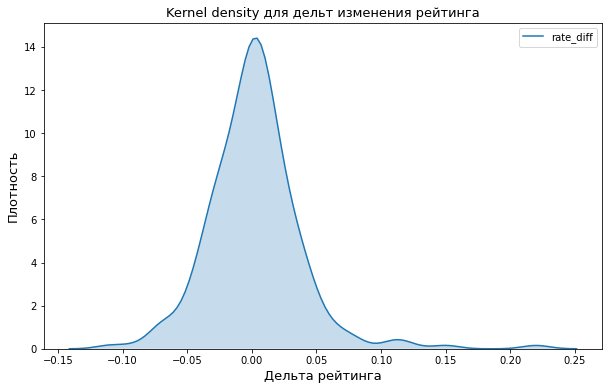

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

f = plt.figure(figsize=(10, 6))
p1 = sns.kdeplot(data['rate_diff'], shade=True)
plt.title('Kernel density для дельт изменения рейтинга', fontsize=13)
plt.xlabel('Дельта рейтинга', fontsize=13)
plt.ylabel('Плотность', fontsize=13)

fig = p1.get_figure
fig

Check for VAR

### Проверяем влияние шока рейтинга на топики

In [168]:
data = pd.read_excel('President (version 3).xlsx')
data.Date = data.Date.apply(lambda x: str(x.date()))
data = data.drop(['Pres_Approve', 'Gov_Approve', 'Right_Direction', 'Governor_Approve',
           'Econom_Maybe', 'Econom_Protest', 'USA_Relation'], axis=1)
data.head(3)

,Date,Was_Line,Crimea,w_Pres_Approve,Delta_Pres_Approve,D_Two_Prescend,B4_Pos_Rating_Shock,B4_Neg_Rating_Shock,Aft_Pos_Rating_Shock,Aft_Neg_Rating_Shock,...,"T7: Inflation, income & employment",T8: Taxation & entrepreneurship,T9: Solving various problems?,T10: Elections and regional government,"T11: Criminality, corruption and law enforcement agencies",T12: Renovation/mortgages & agriculture,"T13: Econ, development & public procurement",T14: Armed forces,"T15: Int, politics & Ukraine",T16: Healthcare & education
0,1999-08-01,0,0,0.31,NaN,NaN,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1999-09-01,0,0,0.53,0.22,NaN,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1999-10-01,0,0,0.65,0.12,NaN,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Получаем даты позитивных/негативных шоков.
#### Маркер шока на году t-i относится к году t, т.к. произошел в период времени [t-i; t]
#### Грубо говоря, маркер говорит "будет ли перед следующим эфиром что-то экстраординарное с рейтингом"

- Так как мы сравниваем prevalence по сравнению с предыдущим годом, поставим маркер шока рейтинга на предыдущий период. Так приходится делать, потому что частота измерения topic prevalence годовая, а рейтинга - ежемесячная
- Шоком считается событие, если рейтинг за последние 1/2/3 месяца перед эфиром вырос или упал в сумме на 5%. 
- Если несколько флагов для "одного шока" стоят подряд, выбирается метка с максимальной дельтой.
- 4 позитивных и 3 негативных шока

In [21]:
pos_shock = list(data.Date[data.B4_Pos_Rating_Shock == 1])
neg_shock = list(data.Date[data.B4_Neg_Rating_Shock == 1])

print(pos_shock, neg_shock)

['2001-12-01', '2002-12-01', '2013-04-01', '2017-06-01'] ['2005-09-01', '2006-10-01', '2007-10-01']


Полная динамика второй темы

In [51]:
sample = data.loc[:,['Date', 'T2: Int, trade, integration and sanctions', 
                     'T4: Export of fossils, reserves and ex, rate',
                     'T13: Econ, development & public procurement']]
sample = sample.set_index('Date')
sample.columns = ['y', 'x0', 'x1']
sample = sample.dropna()
sample.head(3)

,y,x0,x1
Date,,,
2001-12-01,0.066569,0.055052,0.047140
2002-12-01,0.038166,0.050659,0.095209
2003-12-01,0.054516,0.046565,0.091334


Прогнозный байесовский ряд подогнан просто кошмарно. Построить на 16 наблюдениях не получится

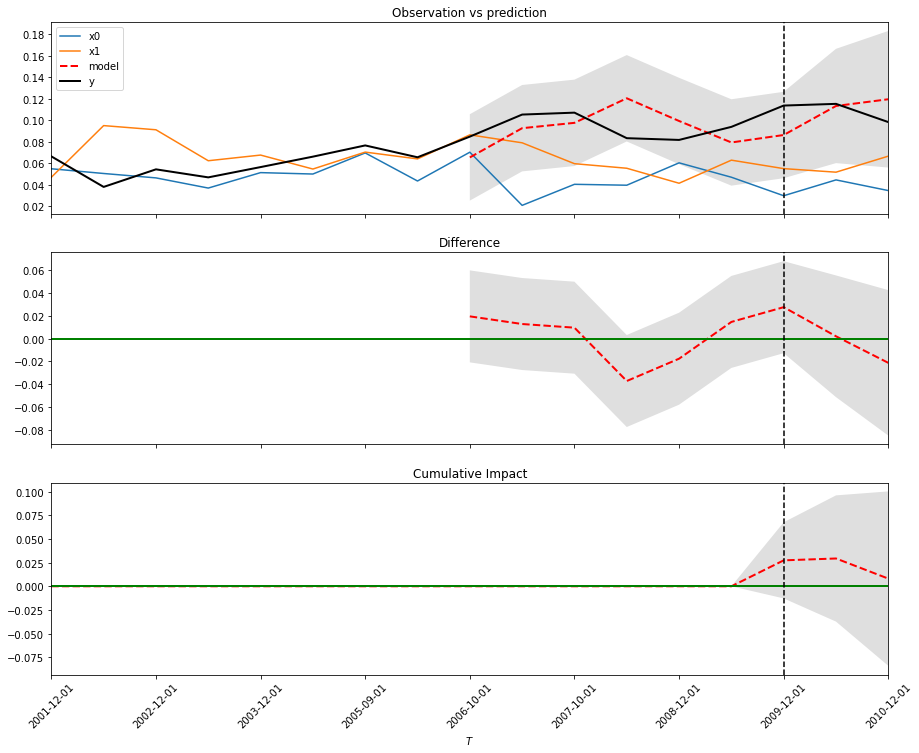

In [47]:
ci = CausalImpact(sample, pos_shock[3])
ci.run(max_iter=2000)
ci.plot()

#### Меняем стратегию. Необходимо оставлять ежемесячный рейтинг в качестве Y, а в качестве интервенций - события с периодичностью прямых линий. Возьмем преобладание топика/сочетаний топиков в качестве ключевых событий 

In [174]:
topics = data.iloc[:, 16:] 
topics.insert(0, 'Date', data.iloc[:,0])
topics.insert(1, 'Delta_Pres_Approve', data['w_Pres_Approve'].diff())
topics.insert(2, 'D_Two_Prescend', data['D_Two_Prescend'])
topics.insert(3, 'Was_Line', data['Was_Line'])
topics.columns = ['Date', 'Delta_Pres_Approve', 'D_Two_Prescend', 'Was_Line', 'T1', 'T2', 'T3', 'T4', 'T5', 
                  'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16']
topics.head(3)

,Date,Delta_Pres_Approve,D_Two_Prescend,Was_Line,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16
0,1999-08-01,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1999-09-01,0.22,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1999-10-01,0.12,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Получаем топики + их возможные комбинации

In [189]:
import itertools
combo = pd.DataFrame({'{}&{}'.format(a, b): topics[a] + topics[b] for a, b in itertools.combinations(topics.iloc[:,4:].columns, 2)})

topics = pd.concat([topics, combo], axis=1)
topics.head(3)

,Date,Delta_Pres_Approve,D_Two_Prescend,Was_Line,T1,T2,T3,T4,T5,T6,...,T13&T15&T13&T16,T13&T15&T14&T15,T13&T15&T14&T16,T13&T15&T15&T16,T13&T16&T14&T15,T13&T16&T14&T16,T13&T16&T15&T16,T14&T15&T14&T16,T14&T15&T15&T16,T14&T16&T15&T16
0,1999-08-01,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1999-09-01,0.22,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1999-10-01,0.12,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [190]:
output = pd.concat([data, topics.iloc[:,20:]], axis=1, ignore_index=True)
cols = list(data.columns) + list(topics.iloc[:,20:].columns)
output.columns = [cols]
output.head(3)
# output.to_excel('President (version 4).xlsx', index=False)

,Date,Was_Line,Crimea,w_Pres_Approve,Delta_Pres_Approve,D_Two_Prescend,B4_Pos_Rating_Shock,B4_Neg_Rating_Shock,Aft_Pos_Rating_Shock,Aft_Neg_Rating_Shock,...,T13&T15&T13&T16,T13&T15&T14&T15,T13&T15&T14&T16,T13&T15&T15&T16,T13&T16&T14&T15,T13&T16&T14&T16,T13&T16&T15&T16,T14&T15&T14&T16,T14&T15&T15&T16,T14&T16&T15&T16
0,1999-08-01,0,0,0.31,NaN,NaN,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1999-09-01,0,0,0.53,0.22,NaN,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1999-10-01,0,0,0.65,0.12,NaN,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Очень информативно. Позже отсеять по значимости

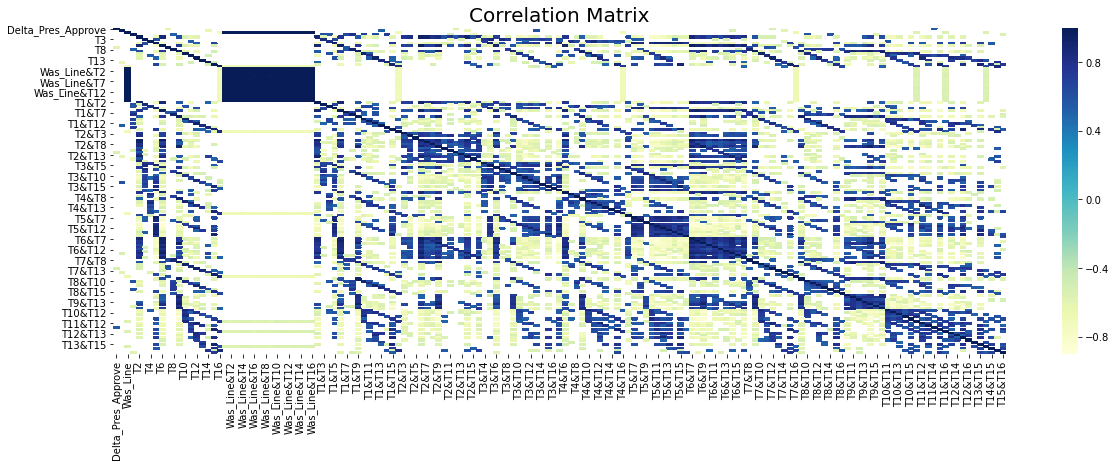

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

to_corr = topics.dropna()
to_corr.drop(['Date', 'Delta_Pres_Approve', 'Was_Line'], axis=1)

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

corr = to_corr.corr()
mask = calculate_pvalues(to_corr)

plt.figure(figsize=(20,6))
plt.title("Correlation Matrix", fontsize =20)

sns_plot =  sns.heatmap(corr, mask=mask > 0.05, 
                        fmt='.2f', cmap="YlGnBu")

fig = sns_plot.get_figure()
fig.savefig("output.png")

Смотрим, что как дельта рейтинга президента за 2 предыдущих месяца влияет на топики

In [13]:
new = pd.concat([corr.loc[:,'D_Two_Prescend'], mask.loc[:,'D_Two_Prescend']], axis=1)
new.columns = ['coef', 'p-value']
new = new[(new['p-value'] <= 0.05) & (new['coef'] < 1)]
new

,coef,p-value
T14,-0.618956,0.0106
T1&T13,0.523165,0.0376
T2&T14,-0.610662,0.012
T3&T13,0.598262,0.0144
T6&T14,-0.521372,0.0383
T7&T14,-0.579797,0.0186
